# Modelling using value of Reproduction Rate

Modelling with R0 as target variable. R0 represents the average number of people infected by one infectious individual. 

## Import libraries

In [257]:
import pandas as pd, numpy as np, time
import datetime
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.metrics import make_scorer
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import pyplot
import lightgbm as lgb
from xgboost import XGBRegressor
import xgboost
from xgboost import plot_importance
from xgboost import plot_tree
from catboost import CatBoostRegressor
from sklearn import preprocessing
import shap
from sklearn.datasets import make_regression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from sklearn.model_selection import TimeSeriesSplit
%matplotlib inline

## Authenticate to Google Drive 
(Request access to lucasbotellaroca@gmail.com if not conceded)
Retrieve all files from different folders

In [181]:
# A browser window will open. Login using the appropriate account.
gauth = GoogleAuth()
gauth.LocalWebserverAuth() #

Your browser has been opened to visit:

    https://accounts.google.com/o/oauth2/auth?client_id=267819126046-3da5rmgml4iemor49ermcv23tnaj02t5.apps.googleusercontent.com&redirect_uri=http%3A%2F%2Flocalhost%3A8080%2F&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&access_type=offline&response_type=code

Authentication successful.


In [182]:
drive = GoogleDrive(gauth)

In [183]:
drive

## Auxiliary Functions

##### read_csv_file(folder, fileName, nrows)
Returns a dataframe, if not found returns empty dataframe

In [184]:
def read_csv_file(folder, fileName, nrows):
    
    read_file = drive.ListFile({'q': "title contains '" + fileName + ".csv' and '" + folder + "' in parents"}).GetList()
    
    if len(read_file)>0:
        title = read_file[0]['title']
        id = read_file[0]['id']
        each_file = drive.CreateFile({'id': id})
        each_file.GetContentFile(title)
        df = pd.read_csv(title, skiprows=nrows)
    else:
        
        df=pd.DataFrame()
    
    return df

##### highlight_min()
Highlights minimum values for every dataframe column

In [185]:
def highlight_min(data):
    return data.style.highlight_min(color = 'lightgreen', 
                       axis = 0)

##### aux_plot_real_vs_pred()
Creates a df with test vs predicted values of R0 and creates a bar plot

In [186]:
def aux_plot_real_vs_pred(approach, y_real, y_pred):
    plt.style.use('ggplot')
    reg_real_vs_pred = pd.DataFrame({'Actual': y_real, 'Predicted': y_pred})
    reg_real_vs_pred = reg_real_vs_pred.head(30)
    reg_real_vs_pred.plot(kind='bar', color=['darksalmon', 'teal'],figsize=(15,5)).set_title('Predicted vs Actual Approach ' + str(approach+1))
    plt.show()

##### plot_aux()
Plots measured vs predicted values for reproduction rate selected in train and test together with the perfect fit line.

In [187]:
def plot_aux(approach, y_test, y_pred, y_train, y_pred_train, ax):
    ax[approach][0].scatter(y_test, y_pred, color='cornflowerblue', alpha=.6)
    ax[approach][0].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'k--', lw=1)
    ax[approach][0].set_title('Test Set Approach ' + str(approach+1))
    ax[approach][0].set_xlabel('Measured')
    ax[approach][0].set_ylabel('Predicted')
    
    ax[approach][1].scatter(y_train, y_pred_train, color='coral', alpha=.8)
    ax[approach][1].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'k--', lw=1)
    ax[approach][1].set_xlabel('Measured')
    ax[approach][1].set_ylabel('Predicted')
    ax[approach][1].set_title('Train Set Approach ' + str(approach+1))
    
    
    ax[approach][2].scatter(y_pred_train,y_train-y_pred_train, color='coral', alpha=.8)
    ax[approach][2].scatter(y_pred,y_test-y_pred, color='cornflowerblue', alpha=.6)
    ax[approach][2].plot([0, y_train.max()], [0, 0], 'k--', lw=1)
    ax[approach][2].set_xlabel('Predicted Value')
    ax[approach][2].set_ylabel('Residuals')
    ax[approach][2].set_title('Residuals Plot Approach ' + str(approach+1))

##### plot_aux_2()
Plots measured vs predicted values for reproduction rate selected in train and test together with the perfect fit line. One single approach

In [188]:
def plot_aux_2(approach, y_test, y_pred, y_train, y_pred_train, ax):
    ax[0].scatter(y_test, y_pred, color='dodgerblue', alpha=.6)
    ax[0].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'k--', lw=1)
    ax[0].set_title('Test Set Approach ' + str(approach+1))
    ax[0].set_xlabel('Measured')
    ax[0].set_ylabel('Predicted')
    
    ax[1].scatter(y_train, y_pred_train, color='indigo', alpha=.6)
    ax[1].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'k--', lw=1)
    ax[1].set_xlabel('Measured')
    ax[1].set_ylabel('Predicted')
    ax[1].set_title('Train Set Approach ' + str(approach+1))
    
    
    ax[2].scatter(y_pred_train,y_train-y_pred_train, color='indigo', alpha=.6)
    ax[2].scatter(y_pred,y_test-y_pred, color='dodgerblue', alpha=.6)
    ax[2].plot([0, y_train.max()], [0, 0], 'k--', lw=1)
    ax[2].set_xlabel('Predicted Value')
    ax[2].set_ylabel('Residuals')
    ax[2].set_title('Residuals Plot Approach ' + str(approach+1))

##### plot_aux_3()
Plots measured vs predicted values for reproduction rate selected in train and test together with the perfect fit line. Available for any model in x,y coordinates of ax axes.

In [426]:
def aux_plot_3(model, x, y, y_test, y_pred, y_train, ax):
    
    ax[x][y].scatter(y_test, y_pred, color='cornflowerblue', alpha=.6)
    ax[x][y].plot([0, 2], [0,2], 'k--', lw=1)
    ax[x][y].set_title(model)
    ax[x][y].set_xlabel('Measured')
    ax[x][y].set_ylabel('Predicted')
    
    ax[x][y].set_xlim([0,2])
    ax[x][y].set_ylim([0,2])

##### get_values_metric()
Returns dataframes ready to plot for coparison three models with three different approaches

In [189]:
def get_values_metric(metric):
    
    df_scores_xgb_rel=pd.DataFrame()
    df_scores_xgb_rel['Train']=df_scores_xgb_train[metric]
    df_scores_xgb_rel['Test']=df_scores_xgb[metric]
    
    df_scores_lgb_rel=pd.DataFrame()
    df_scores_lgb_rel['Train']=df_scores_lgb_train[metric]
    df_scores_lgb_rel['Test']=df_scores_lgb[metric]
    
    df_scores_gbst_rel=pd.DataFrame()
    df_scores_gbst_rel['Train']=df_scores_train_gbr[metric]
    df_scores_gbst_rel['Test']=df_scores_gbr[metric]
    
    df_scores_knn_rel=pd.DataFrame()
    df_scores_knn_rel['Train']=df_scores_knn_train[metric]
    df_scores_knn_rel['Test']=df_scores_knn[metric]
    
    df_scores_hist_rel=pd.DataFrame()
    df_scores_hist_rel['Train']=df_scores_hist_train[metric]
    df_scores_hist_rel['Test']=df_scores_hist[metric]
    
    df_scores_NuSVR_rel=pd.DataFrame()
    df_scores_NuSVR_rel['Train']=df_scores_NuSVR_train[metric]
    df_scores_NuSVR_rel['Test']=df_scores_NuSVR[metric]
    
    return df_scores_xgb_rel,df_scores_lgb_rel, df_scores_gbst_rel, df_scores_knn_rel, df_scores_hist_rel, df_scores_NuSVR_rel

##### get_metrics_data_frame()
Returns mae, mse, rmse and mape for passed values

In [190]:
def get_metrics_data_frame(y_appch1,y_pred_1,y_appch2,y_pred_2, y_appch3, y_pred_3):

    mae_1 = mean_absolute_error(y_appch1, y_pred_1)
    mse_1 = mean_squared_error(y_appch1, y_pred_1)
    rmse_1 = np.sqrt(mean_squared_error(y_appch1, y_pred_1))
    r2_1 = r2_score(y_appch1, y_pred_1)
    mape_1 = np.mean(np.abs((y_appch1 - y_pred_1) / y_appch1)) * 100

    mae_2 = mean_absolute_error(y_appch2, y_pred_2)
    mse_2 = mean_squared_error(y_appch2, y_pred_2)
    rmse_2 = np.sqrt(mean_squared_error(y_appch2, y_pred_2))
    r2_2 = r2_score(y_appch2, y_pred_2)
    mape_2 = np.mean(np.abs((y_appch2 - y_pred_2) / y_appch2)) * 100

    mae_3 = mean_absolute_error(y_appch3, y_pred_3)
    mse_3 = mean_squared_error(y_appch3, y_pred_3)
    rmse_3 = np.sqrt(mean_squared_error(y_appch3, y_pred_3))
    r2_3 = r2_score(y_appch3, y_pred_3)
    mape_3 = np.mean(np.abs((y_appch3 - y_pred_3) / y_appch3)) * 100

    scores = { 'mae' : {'Approach 1': mae_1, 'Approach 2': mae_2, 'Approach 3': mae_3},
               'mse' : {'Approach 1': mse_1, 'Approach 2': mse_2, 'Approach 3': mse_3},
               'rmse' : {'Approach 1': rmse_1, 'Approach 2': rmse_2, 'Approach 3': rmse_3}, 
               'mape' : {'Approach 1':mape_1, 'Approach 2':mape_2, 'Approach 3':mape_3} }
    
    df_scores=pd.DataFrame(scores)
    
    return df_scores

## Read file and prepare data 

In [475]:
#df=pd.read_csv('df_covid_processed_final_reproduction_rate.csv')
df=read_csv_file('1EsuOqiCqQK5HSCI3aPOvOUq2kXsXd5uH','df_covid_processed_final_reproduction_rate',0)
del df['Unnamed: 0']

#Selected columns for our analysis
df=df[['Code', 'Date', 'retail_and_recreation',
       'grocery_and_pharmacy', 'residential', 'transit_stations', 'parks',
       'workplaces', 'debt_relief', 'income_support', 'testing_policy',
       'international_travel_controls', 'restrictions_internal_movements',
       'close_public_transport', 'public_information_campaigns',
       'facial_coverings', 'contact_tracing', 
       'stay_home_requirements', 'restriction_gatherings',
       'cancel_public_events', 'workplace_closures', 'school_closures',
       'holiday', 'temp', 'prcp', 'number_of_arrivals', 'urban_population',
      'total_vaccinations_per_100', 'youth_unemployment','infections_value',
      'accumulated', 'reproduction_rate']]

#Simply remove rows with missing infectious or accumulated values.
df = df[df['infections_value'].notna()]
df = df[df['accumulated'].notna()]

#If vacciantions are null will replace them by zeros.
df['total_vaccinations_per_100'] = df['total_vaccinations_per_100'].fillna(0)

#We replace values smaller than zero to, since there are no "negative infections"
df['infections_value'][df['infections_value'] < 0] = 0
df

,Code,Date,retail_and_recreation,grocery_and_pharmacy,residential,transit_stations,parks,workplaces,debt_relief,income_support,...,holiday,temp,prcp,number_of_arrivals,urban_population,total_vaccinations_per_100,youth_unemployment,infections_value,accumulated,reproduction_rate
0,AUS,2020-03-22,0.714429,8.979571,-0.387571,5.448857,-2.857143,8.326571,0.000000,0.0,...,0.0,21.346512,0.142010,8263000.0,85.904,0.000000,11.84,7.28,0.002502,2.170000
1,AUS,2020-03-29,-0.898000,15.163286,0.448857,-1.061286,-4.959143,6.959000,0.000000,1.0,...,0.0,21.176835,0.054789,8263000.0,85.904,0.000000,11.84,12.13,0.003071,2.330000
2,AUS,2020-04-05,-10.591857,22.020286,5.102143,-21.836714,-14.836714,-0.918286,0.285714,1.0,...,0.0,20.702945,0.051898,8263000.0,85.904,0.000000,11.84,11.31,0.003808,2.280000
3,AUS,2020-04-12,-32.163429,-0.020429,13.428429,-48.775571,-28.183714,-22.816286,2.000000,1.0,...,0.0,21.093375,0.073336,8263000.0,85.904,0.000000,11.84,6.36,0.005034,1.457143
4,AUS,2020-04-19,-40.918429,-12.347143,17.612143,-60.204143,-39.326571,-35.265286,2.000000,1.0,...,0.0,18.880697,0.118556,8263000.0,85.904,0.000000,11.84,2.95,0.006178,0.765714
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3572,USA,2021-01-31,-24.673429,-12.857143,10.795714,-40.183714,-19.183714,-28.816286,1.000000,2.0,...,1.0,3.141409,0.027324,75608000.0,82.058,4.160000,8.30,28.11,0.217541,0.892857
3573,USA,2021-02-07,-25.836714,-14.142714,10.734429,-41.285714,-21.000143,-28.816143,1.000000,2.0,...,0.0,1.441940,0.060531,75608000.0,82.058,6.405714,8.30,25.01,0.223260,0.848571
3574,USA,2021-02-14,-25.938714,-14.551000,10.714000,-41.714286,-25.775714,-27.938714,1.000000,2.0,...,0.0,0.586187,0.055322,75608000.0,82.058,9.125714,8.30,15.60,0.228214,0.825714
3575,USA,2021-02-21,-24.489857,-12.326571,10.142857,-40.591714,-23.285714,-27.489714,1.000000,2.0,...,0.0,-1.192456,0.032941,75608000.0,82.058,12.074286,8.30,12.85,0.232621,0.780000


In [476]:
df[df['infections_value'] < 0]

,Code,Date,retail_and_recreation,grocery_and_pharmacy,residential,transit_stations,parks,workplaces,debt_relief,income_support,...,holiday,temp,prcp,number_of_arrivals,urban_population,total_vaccinations_per_100,youth_unemployment,infections_value,accumulated,reproduction_rate


Text(0.5, 1.0, 'reproduction_rate')

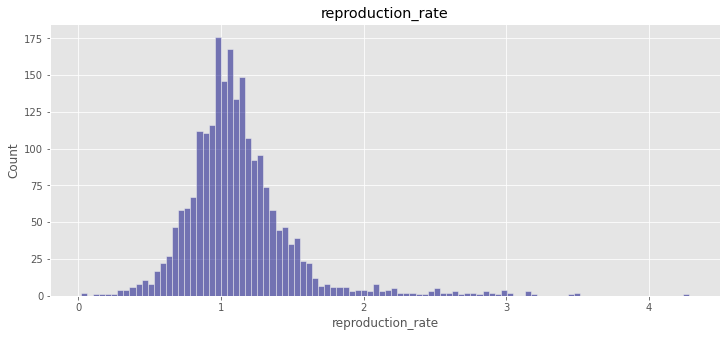

In [477]:
#Removing -inf and infinite
df=df[~df.isin([np.inf, -np.inf]).any(1)]
f, axes = plt.subplots(figsize=(12,5))
sns.histplot(x='reproduction_rate', data=df, kde=False, bins=100, ax=axes, color='navy', alpha=.5);
axes.set_title('reproduction_rate')

In [478]:
df.columns

Index(['Code', 'Date', 'retail_and_recreation', 'grocery_and_pharmacy',
       'residential', 'transit_stations', 'parks', 'workplaces', 'debt_relief',
       'income_support', 'testing_policy', 'international_travel_controls',
       'restrictions_internal_movements', 'close_public_transport',
       'public_information_campaigns', 'facial_coverings', 'contact_tracing',
       'stay_home_requirements', 'restriction_gatherings',
       'cancel_public_events', 'workplace_closures', 'school_closures',
       'holiday', 'temp', 'prcp', 'number_of_arrivals', 'urban_population',
       'total_vaccinations_per_100', 'youth_unemployment', 'infections_value',
       'accumulated', 'reproduction_rate'],
      dtype='object')

## Feature Engineering

### Approach 1: Raw data no grouping of variables or PCA Analysis
Train models with raw data, no previous transformation or grouping done

In [479]:
df_appch1=df.copy()
df_appch1_clean=df.copy()

In [480]:
df_appch1_clean['prcp'] = df_appch1_clean['prcp'].fillna(df_appch1_clean['prcp'].mean())
df_appch1_clean['temp'] = df_appch1_clean['temp'].fillna(df_appch1_clean['temp'].mean())
df_appch1_clean['parks'] = df_appch1_clean['parks'].fillna(df_appch1_clean['prcp'].mean())
df_appch1_clean['number_of_arrivals'] = df_appch1_clean['number_of_arrivals'].fillna(df_appch1_clean['number_of_arrivals'].mean())
df_appch1_clean['urban_population'] = df_appch1_clean['urban_population'].fillna(df_appch1_clean['urban_population'].mean())
df_appch1_clean['total_vaccinations_per_100'] = df_appch1_clean['total_vaccinations_per_100'].fillna(0)
df_appch1_clean['youth_unemployment']= df_appch1_clean['youth_unemployment'].fillna(df_appch1_clean['youth_unemployment'].mean())
df_appch1_clean = df_appch1_clean[df_appch1_clean['infections_value'].notna()]
df_appch1_clean = df_appch1_clean[df_appch1_clean['retail_and_recreation'].notna()]
df_appch1_clean = df_appch1_clean[df_appch1_clean['grocery_and_pharmacy'].notna()]
df_appch1_clean['accumulated']= df_appch1_clean['accumulated'].fillna(df_appch1_clean['accumulated'].mean())

### Approach 2: Grouping variables, decreasing dimensionality and correlation
Since variables seem to have high multicollinearity will group variables with similar corellation

In [481]:
df_appch2=df.copy()

In [482]:
#We define bad mobility as the weighted average of mobility trends that have a positive impact on covid spread
df_appch2['mobility_index']=(df_appch2['retail_and_recreation']*0.4+df_appch2['transit_stations']*0.4
                           +df_appch2['grocery_and_pharmacy']*0.1+df_appch2['workplaces']*0.1)

df_appch2['awareness_measures'] = df_appch2['public_information_campaigns']*0.2+df_appch2['facial_coverings']*0.8

df_appch2['economic_measures']=df_appch2['debt_relief']*0.5+df_appch2['income_support']*0.5
df_appch2['health_measures']=df_appch2['contact_tracing']*0.5+df_appch2['testing_policy']*0.5
df_appch2['mobility_measures']=0.3*df_appch2['stay_home_requirements']\
                                + 0.3*df_appch2['restriction_gatherings']\
                                + 0.2*df_appch2['restrictions_internal_movements']\
                                + 0.1*df_appch2['international_travel_controls']\
                                + 0.1*df_appch2['close_public_transport']\
                    

df_appch2['closure_measures'] = 0.2*df_appch2['cancel_public_events']\
                                + 0.4*df_appch2['workplace_closures']\
                                + 0.4*df_appch2['school_closures']

df_appch2=df_appch2[['Code', 'Date','mobility_index', 'residential',
                     'awareness_measures', 'health_measures',
                     'mobility_measures', 'economic_measures',
                     'closure_measures',
                     'holiday', 'temp', 'prcp', 
                     'number_of_arrivals', 'urban_population',
                     'total_vaccinations_per_100', 'youth_unemployment',
                     'infections_value', 'accumulated', 'reproduction_rate']]

In [483]:
df_appch2.head()

,Code,Date,mobility_index,residential,awareness_measures,health_measures,mobility_measures,economic_measures,closure_measures,holiday,temp,prcp,number_of_arrivals,urban_population,total_vaccinations_per_100,youth_unemployment,infections_value,accumulated,reproduction_rate
0,AUS,2020-03-22,4.195929,-0.387571,0.4,1.5,0.300000,0.000000,0.000000,0.0,21.346512,0.142010,8263000.0,85.904,0.0,11.84,7.28,0.002502,2.170000
1,AUS,2020-03-29,1.428514,0.448857,0.4,1.5,0.557143,0.500000,0.114286,0.0,21.176835,0.054789,8263000.0,85.904,0.0,11.84,12.13,0.003071,2.330000
2,AUS,2020-04-05,-10.861229,5.102143,0.4,1.5,1.557143,0.642857,1.085714,0.0,20.702945,0.051898,8263000.0,85.904,0.0,11.84,11.31,0.003808,2.280000
3,AUS,2020-04-12,-34.659271,13.428429,0.4,1.5,2.171429,1.500000,2.400000,0.0,21.093375,0.073336,8263000.0,85.904,0.0,11.84,6.36,0.005034,1.457143
4,AUS,2020-04-19,-45.210271,17.612143,0.4,1.5,2.600000,1.500000,2.400000,0.0,18.880697,0.118556,8263000.0,85.904,0.0,11.84,2.95,0.006178,0.765714


<AxesSubplot:>

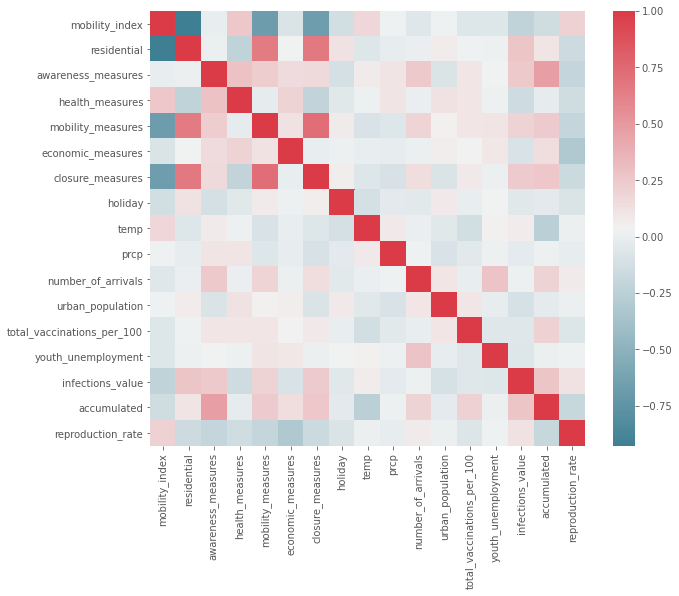

In [484]:
f, ax = plt.subplots(figsize=(10, 8))
corr = df_appch2.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)

In [485]:
df_appch2_clean=df_appch2.copy()
df_appch2_clean['prcp'] = df_appch2_clean['prcp'].fillna(df_appch2_clean['prcp'].mean())
df_appch2_clean['temp'] = df_appch2_clean['temp'].fillna(df_appch2_clean['temp'].mean())
df_appch2_clean['number_of_arrivals'] = df_appch2_clean['number_of_arrivals'].fillna(df_appch2_clean['number_of_arrivals'].mean())
df_appch2_clean['urban_population'] = df_appch2_clean['urban_population'].fillna(df_appch2_clean['urban_population'].mean())
df_appch2_clean['total_vaccinations_per_100'] = df_appch2_clean['total_vaccinations_per_100'].fillna(0)
df_appch2_clean['youth_unemployment']= df_appch2_clean['youth_unemployment'].fillna(df_appch2_clean['youth_unemployment'].mean())
df_appch2_clean = df_appch2_clean[df_appch2_clean['infections_value'].notna()]
df_appch2_clean['accumulated']= df_appch2_clean['accumulated'].fillna(df_appch2_clean['accumulated'].mean())

In [486]:
df_appch2_clean.columns

Index(['Code', 'Date', 'mobility_index', 'residential', 'awareness_measures',
       'health_measures', 'mobility_measures', 'economic_measures',
       'closure_measures', 'holiday', 'temp', 'prcp', 'number_of_arrivals',
       'urban_population', 'total_vaccinations_per_100', 'youth_unemployment',
       'infections_value', 'accumulated', 'reproduction_rate'],
      dtype='object')

### Approach 3: PCA
Since variables have a high correlation we will group variables taking use of Principal Component Analysis

In [487]:
df_appch3=df.copy()
df_appch3['total_vaccinations_per_100'] = df_appch3['total_vaccinations_per_100'].fillna(0)
df_appch3['accumulated'] = df_appch3['accumulated'].fillna(0)
df_appch3['urban_population'] = df_appch3['urban_population'].fillna(df_appch3['urban_population'].mean())
df_appch3['parks'] = df_appch3['parks'].fillna(df_appch3['parks'].mean())
df_appch3['temp'] = df_appch3['temp'].fillna(df_appch3['temp'].mean())
df_appch3['prcp'] = df_appch3['prcp'].fillna(df_appch3['prcp'].mean())
df_appch3 = df_appch3[df_appch3['retail_and_recreation'].notna()]
df_appch3 = df_appch3[df_appch3['grocery_and_pharmacy'].notna()]
df_appch3['youth_unemployment']= df_appch3['youth_unemployment'].fillna(df_appch3['youth_unemployment'].mean())
df_appch3['number_of_arrivals']=df_appch3['number_of_arrivals'].fillna(df_appch3['number_of_arrivals'].mean())
df_appch3 = df_appch3[df_appch3['infections_value'].notna()]

In [488]:
df_appch3.columns

Index(['Code', 'Date', 'retail_and_recreation', 'grocery_and_pharmacy',
       'residential', 'transit_stations', 'parks', 'workplaces', 'debt_relief',
       'income_support', 'testing_policy', 'international_travel_controls',
       'restrictions_internal_movements', 'close_public_transport',
       'public_information_campaigns', 'facial_coverings', 'contact_tracing',
       'stay_home_requirements', 'restriction_gatherings',
       'cancel_public_events', 'workplace_closures', 'school_closures',
       'holiday', 'temp', 'prcp', 'number_of_arrivals', 'urban_population',
       'total_vaccinations_per_100', 'youth_unemployment', 'infections_value',
       'accumulated', 'reproduction_rate'],
      dtype='object')

In [489]:
features=['retail_and_recreation', 'grocery_and_pharmacy',
       'residential', 'transit_stations', 'parks', 'workplaces', 'debt_relief',
       'income_support', 'testing_policy', 'international_travel_controls',
       'restrictions_internal_movements', 'close_public_transport',
       'public_information_campaigns', 'facial_coverings', 'contact_tracing',
       'stay_home_requirements', 'restriction_gatherings',
       'cancel_public_events', 'workplace_closures', 'school_closures',
       'holiday', 'temp', 'prcp', 'total_vaccinations_per_100',
       'infections_value', 'accumulated', 'reproduction_rate']

# Separating out the features
x = df_appch3.reindex(columns = features).values
# Separating out the target
y = df_appch3.reindex(columns = ['reproduction_rate']).values
# Standardizing the features
x = StandardScaler().fit_transform(x)

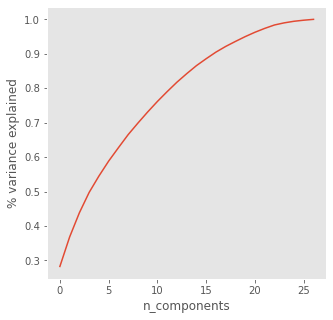

In [490]:
pca = PCA(n_components = x.shape[1])
pca_data = pca.fit_transform(x)

percent_var_explained = pca.explained_variance_/(np.sum(pca.explained_variance_))
cumm_var_explained = np.cumsum(percent_var_explained)

plt.rcParams["figure.figsize"] = (5,5)
plt.plot(cumm_var_explained)
plt.grid()
plt.xlabel("n_components")
plt.ylabel("% variance explained")
plt.show()

In [491]:
pca = PCA(n_components = 15)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents)
#Include Date and R0 for later filtering
principalDf['Date']=df_appch3['Date']
principalDf['reproduction_rate']=df_appch3['reproduction_rate']
df_appch3=principalDf

## Modelling and Evaluation

Once we have our three datasets defined and have an intuition on how our trees should look like will start with the modelling and evaluation phase

In [492]:
date=pd.Timestamp(2021, 1, 10)

#### Approach 1: Raw data no grouping of variables or PCA Analysis Split

In [493]:
X_1=df_appch1[(pd.to_datetime(df_appch1['Date']) <= date)]
X_2=df_appch1[(pd.to_datetime(df_appch1['Date']) > date)]
X_train_appch1=X_1[X_1.columns[2:-1]]
X_test_appch1=X_2[X_2.columns[2:-1]]
y_train_appch1=X_1['reproduction_rate']
y_test_appch1=X_2['reproduction_rate']

In [494]:
X_1_clean=df_appch1_clean[(pd.to_datetime(df_appch1_clean['Date']) <= date)]
X_2_clean=df_appch1_clean[(pd.to_datetime(df_appch1_clean['Date']) > date)]
scaler = preprocessing.StandardScaler().fit(df_appch1_clean[df_appch1_clean.columns[2:-1]])

X_train_appch1_clean = scaler.transform(X_1_clean[X_1_clean.columns[2:-1]])
X_test_appch1_clean = scaler.transform(X_2_clean[X_2_clean.columns[2:-1]])

y_train_appch1_clean=X_1_clean['reproduction_rate']
y_test_appch1_clean=X_2_clean['reproduction_rate']

####  Approach 2: Grouping variables, decreasing dimensionality and correlation Split

In [495]:
X_1=df_appch2[(pd.to_datetime(df_appch2['Date']) <= date)]
X_2=df_appch2[(pd.to_datetime(df_appch2['Date']) > date)]
X_train_appch2=X_1[X_1.columns[2:-1]]
X_test_appch2=X_2[X_2.columns[2:-1]]
y_train_appch2=X_1['reproduction_rate']
y_test_appch2=X_2['reproduction_rate']

In [496]:
X_1_clean=df_appch2_clean[(pd.to_datetime(df_appch2_clean['Date']) <= date)]
X_2_clean=df_appch2_clean[(pd.to_datetime(df_appch2_clean['Date']) > date)]
scaler_appch2 = preprocessing.StandardScaler().fit(df_appch2_clean[df_appch2_clean.columns[2:-1]])

X_train_appch2_clean = scaler_appch2.transform(X_1_clean[X_1_clean.columns[2:-1]])
X_test_appch2_clean = scaler_appch2.transform(X_2_clean[X_2_clean.columns[2:-1]])

y_train_appch2_clean=X_1_clean['reproduction_rate']
y_test_appch2_clean=X_2_clean['reproduction_rate']

#### Approach 3: PCA  Split

In [497]:
X_1=df_appch3[(pd.to_datetime(df_appch3['Date']) <= date)]
X_2=df_appch3[(pd.to_datetime(df_appch3['Date']) > date)]
X_train_appch3=X_1[X_1.columns[0:-2]]
X_test_appch3=X_2[X_2.columns[0:-2]]
y_train_appch3=X_1['reproduction_rate']
y_test_appch3=X_2['reproduction_rate']

In [498]:
X_train_appch3_clean=X_train_appch3
X_test_appch3_clean=X_test_appch3
y_train_appch3_clean=y_train_appch3
y_test_appch3_clean=y_test_appch3

#### Dataframe for later evaluation of approach 2

In [499]:
df_eval_approach_2=pd.DataFrame(columns=['mae','mse','mape','rmse'])

## XGBoost Regressor 

### Modelling
We will model with the restriction observed in the previous section analyzing posible tuning in the parameters for Grid Search CV, for each of the three different approaches

In [500]:
# A parameter grid for XGBoost
fit_params1={'max_depth' : [4,6,8], 'colsample_bytree':[0.5]}
fit_params2={'max_depth' : [5,6,7], 'colsample_bytree':[0.5]}
fit_params3={'max_depth' : [8,9,10], 'colsample_bytree':[0.5]}

# Initialize XGB and GridSearch
xgb = XGBRegressor() 

grid1_xgb = GridSearchCV(xgb, fit_params1, verbose=0, n_jobs=-1)
grid2_xgb = GridSearchCV(xgb, fit_params2, verbose=0, n_jobs=-1)
grid3_xgb = GridSearchCV(xgb, fit_params3, verbose=0, n_jobs=-1)

In [501]:
%time

eval_set1 = [(X_train_appch1, y_train_appch1), (X_test_appch1, y_test_appch1)]
eval_set2 = [(X_train_appch2, y_train_appch2), (X_test_appch2, y_test_appch2)]
eval_set3 = [(X_train_appch3, y_train_appch3), (X_test_appch3, y_test_appch3)]

grid1_xgb.fit(X_train_appch1, y_train_appch1, eval_set=eval_set1, early_stopping_rounds=5, verbose=False)
grid2_xgb.fit(X_train_appch2, y_train_appch2, eval_set=eval_set2, early_stopping_rounds=5, verbose=False)
grid3_xgb.fit(X_train_appch3, y_train_appch3, eval_set=eval_set3, early_stopping_rounds=5, verbose=False)

CPU times: user 16 µs, sys: 7 µs, total: 23 µs
Wall time: 3.61 ms


GridSearchCV(estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, gamma=None,
                                    gpu_id=None, importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=None, min_child_weight=None,
                                    missing=nan, monotone_constraints=None,
                                    n_estimators=100, n_jobs=None,
                                    num_parallel_tree=None, random_state=None,
                                    reg_alpha=None, reg_lambda=None,
                                    scale_pos_weight=None, subsample=None,
                                    tree_method=None, validate_parameters=None,
      

In [502]:
grid2_xgb.best_estimator_

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.5, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=5,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [503]:
y_pred_1_xgb=grid1_xgb.best_estimator_.predict(X_test_appch1)
y_pred_train_1_xgb=grid1_xgb.best_estimator_.predict(X_train_appch1)
y_pred_2_xgb=grid2_xgb.best_estimator_.predict(X_test_appch2)
y_pred_train_2_xgb=grid2_xgb.best_estimator_.predict(X_train_appch2)
y_pred_3_xgb=grid3_xgb.best_estimator_.predict(X_test_appch3)
y_pred_train_3_xgb=grid3_xgb.best_estimator_.predict(X_train_appch3)

### XGB Evaluation

#### Test Set

In [504]:
df_scores_xgb=get_metrics_data_frame(y_test_appch1,y_pred_1_xgb, y_test_appch2, y_pred_2_xgb,y_test_appch3, y_pred_3_xgb)
df_eval_approach_2.loc['XGBoost Regressor'] = df_scores_xgb.loc['Approach 2']
highlight_min(df_scores_xgb)

,mae,mse,rmse,mape
Approach 1,0.150281,0.036037,0.189834,15.386554
Approach 2,0.148949,0.034279,0.185147,14.709373
Approach 3,0.148393,0.036313,0.190559,15.046792


#### Train Set

In [505]:
df_scores_xgb_train=get_metrics_data_frame(y_train_appch1,y_pred_train_1_xgb, y_train_appch2, y_pred_train_2_xgb,y_train_appch3, y_pred_train_3_xgb)
highlight_min(df_scores_xgb_train)

,mae,mse,rmse,mape
Approach 1,0.146243,0.041210,0.203002,15.747099
Approach 2,0.152394,0.043515,0.208603,16.254807
Approach 3,0.231895,0.120697,0.347415,18.035275


## Results View

#### Actual vs Predicted

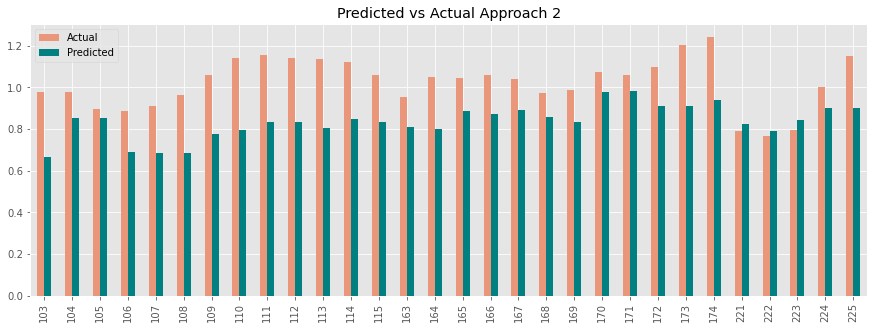

In [506]:
aux_plot_real_vs_pred(1, y_test_appch2, y_pred_2_xgb)

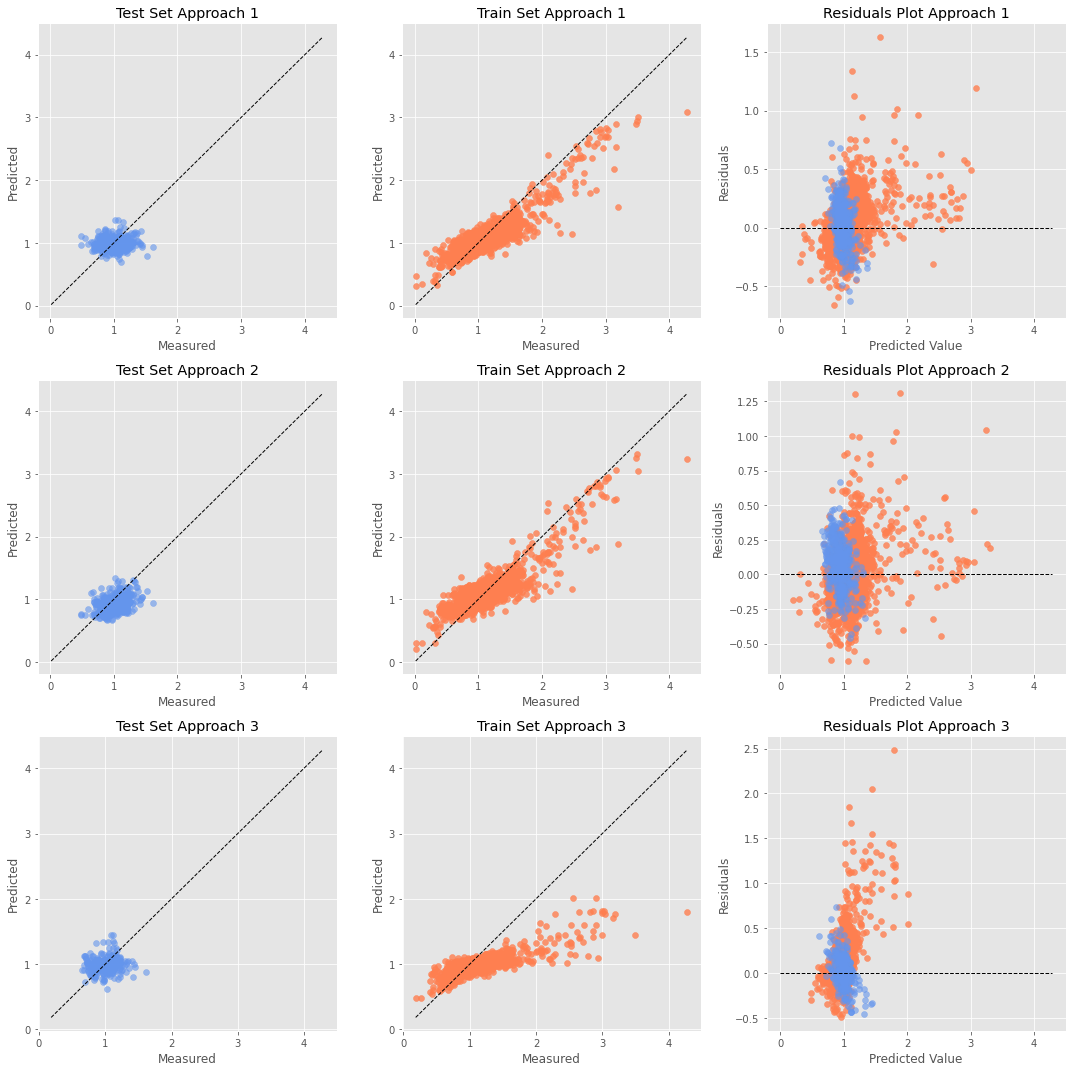

In [507]:
fig, ax = plt.subplots(3,3,figsize=(15,15))

plot_aux(0, y_test_appch1, y_pred_1_xgb, y_train_appch1, y_pred_train_1_xgb, ax)
plot_aux(1, y_test_appch2, y_pred_2_xgb, y_train_appch2, y_pred_train_2_xgb, ax)
plot_aux(2, y_test_appch3, y_pred_3_xgb, y_train_appch3, y_pred_train_3_xgb, ax)

fig.tight_layout()
plt.show()

* As seen Approach 3 using PCA seems to be the one getting the "best" results. However none of them seem to be fitting R0 correctly specially with larger values of R0.
* It is also important to note that the test set has a smaller rangeof values

## Light GBM

### Modelling 

In [508]:
fit_params1={'n_estimators':[19,20,21],'max_depth' : [8,9,10]}
fit_params2={'n_estimators':[26,27,28],'max_depth' : [7,8,9]}
fit_params3={'n_estimators':[15,20,25],'max_depth' : [16,17,18]}


# Initialize LGB and GridSearch
lgbm = lgb.LGBMRegressor()

grid1_lgb = GridSearchCV(lgbm, fit_params1, verbose=0)
grid2_lgb = GridSearchCV(lgbm, fit_params2, verbose=0)
grid3_lgb = GridSearchCV(lgbm, fit_params3, verbose=0)

In [509]:
%%time

eval_set1 = [(X_train_appch1, y_train_appch1), (X_test_appch1, y_test_appch1)]
eval_set2 = [(X_train_appch2, y_train_appch2), (X_test_appch2, y_test_appch2)]
eval_set3 = [(X_train_appch3, y_train_appch3), (X_test_appch3, y_test_appch3)]

grid1_lgb.fit(X_train_appch1, y_train_appch1, eval_set=eval_set1, verbose=False)
grid2_lgb.fit(X_train_appch2, y_train_appch2, eval_set=eval_set2, verbose=False)
grid3_lgb.fit(X_train_appch3, y_train_appch3, eval_set=eval_set3, verbose=False)

CPU times: user 34.5 s, sys: 1.23 s, total: 35.8 s
Wall time: 10.4 s


GridSearchCV(estimator=LGBMRegressor(),
             param_grid={'max_depth': [16, 17, 18],
                         'n_estimators': [15, 20, 25]})

In [510]:
grid1_lgb.best_params_, grid2_lgb.best_params_, grid3_lgb.best_params_

({'max_depth': 8, 'n_estimators': 19},
 {'max_depth': 8, 'n_estimators': 26},
 {'max_depth': 16, 'n_estimators': 15})

In [511]:
y_pred_1_lgb=grid1_lgb.best_estimator_.predict(X_test_appch1)
y_pred_train_1_lgb=grid1_lgb.best_estimator_.predict(X_train_appch1)
y_pred_2_lgb=grid2_lgb.best_estimator_.predict(X_test_appch2)
y_pred_train_2_lgb=grid2_lgb.best_estimator_.predict(X_train_appch2)
y_pred_3_lgb=grid3_lgb.best_estimator_.predict(X_test_appch3)
y_pred_train_3_lgb=grid3_lgb.best_estimator_.predict(X_train_appch3)

### Evaluation

#### Test Set

In [512]:
df_scores_lgb=get_metrics_data_frame(y_test_appch1,y_pred_1_lgb, y_test_appch2, y_pred_2_lgb,y_test_appch3, y_pred_3_lgb)
df_eval_approach_2.loc['Light GBM'] = df_scores_lgbm.loc['Approach 2']
highlight_min(df_scores_lgbm)

,mae,mse,rmse,mape
Approach 1,0.141330,0.031909,0.178630,14.276794
Approach 2,0.127071,0.027187,0.164884,13.355917
Approach 3,0.205836,0.064894,0.254743,22.624595


#### Train Set

In [513]:
df_scores_lgb_train=get_metrics_data_frame(y_train_appch1,y_pred_train_1_lgb, y_train_appch2, y_pred_train_2_lgb,y_train_appch3, y_pred_train_3_lgb)
highlight_min(df_scores_lgbm_train)

,mae,mse,rmse,mape
Approach 1,0.162093,0.054631,0.233733,20.442758
Approach 2,0.171793,0.059270,0.243455,20.924862
Approach 3,0.198350,0.089471,0.299118,18.772408


## Results View

#### Actual vs Predicted

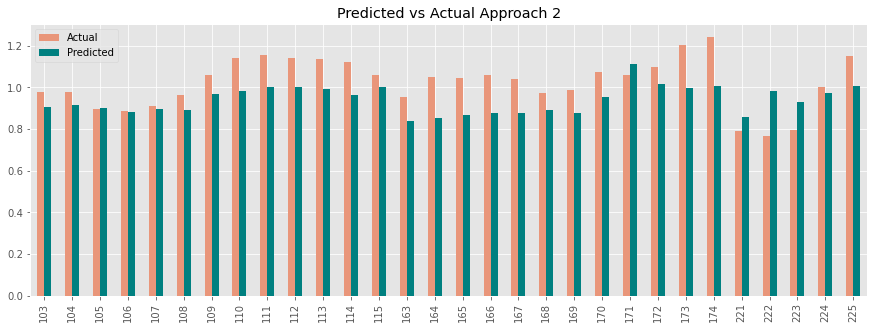

In [514]:
aux_plot_real_vs_pred(1, y_test_appch2, y_pred_2_lgb)

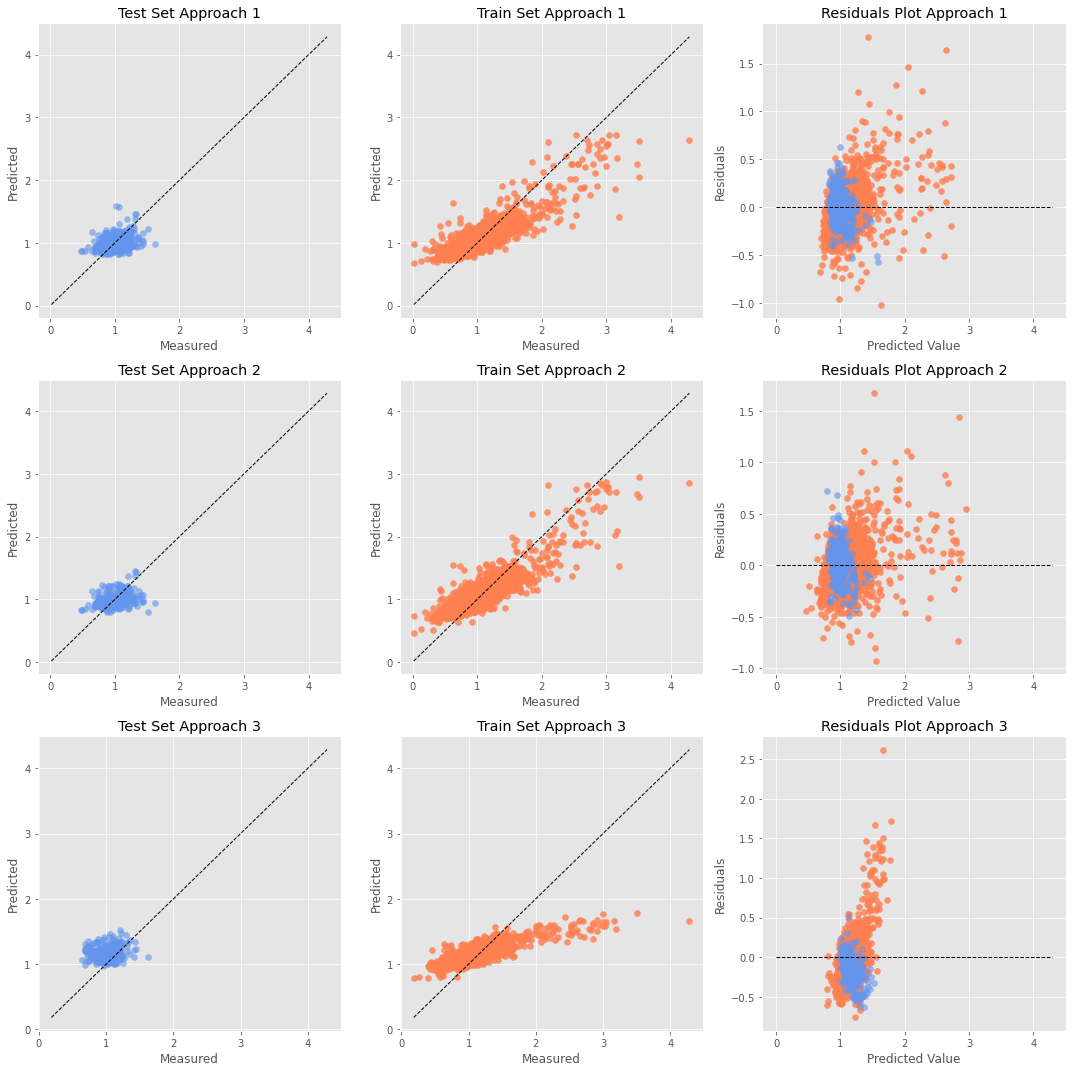

In [515]:
fig, ax = plt.subplots(3,3,figsize=(15,15))

plot_aux(0, y_test_appch1, y_pred_1_lgb, y_train_appch1, y_pred_train_1_lgb, ax)
plot_aux(1, y_test_appch2, y_pred_2_lgb, y_train_appch2, y_pred_train_2_lgb, ax)
plot_aux(2, y_test_appch3, y_pred_3_lgb, y_train_appch3, y_pred_train_3_lgb, ax)

fig.tight_layout()
plt.show()

* As seen Approach 3 using PCA seems to be the one getting the "best" results. However none of them seem to be fitting R0 correctly specially with larger values of R0.
* It is also important to note that the test set has a smaller rangeof values

## Gradient Boosting Regressor 

In [516]:
reg1_gbr = GradientBoostingRegressor()
reg2_gbr = GradientBoostingRegressor()
reg3_gbr = GradientBoostingRegressor()

reg1_gbr.fit(X_train_appch1_clean, y_train_appch1_clean)
reg2_gbr.fit(X_train_appch2_clean, y_train_appch2_clean)
reg3_gbr.fit(X_train_appch3_clean, y_train_appch3_clean)


y_pred_1_gbr=reg1_gbr.predict(X_test_appch1_clean)
y_pred_train_1_gbr=reg1_gbr.predict(X_train_appch1_clean)
y_pred_2_gbr=reg2_gbr.predict(X_test_appch2_clean)
y_pred_train_2_gbr=reg2_gbr.predict(X_train_appch2_clean)
y_pred_3_gbr=reg3_gbr.predict(X_test_appch3_clean)
y_pred_train_3_gbr=reg3_gbr.predict(X_train_appch3_clean)

### Evaluation

#### Test Set

In [517]:
df_scores_gbr=get_metrics_data_frame(y_test_appch1_clean,y_pred_1_gbr, y_test_appch2_clean, y_pred_2_gbr,y_test_appch3_clean, y_pred_3_gbr)
df_eval_approach_2.loc['Gradient Boosting'] = df_scores_gbr.loc['Approach 2']
highlight_min(df_scores_gbr)

,mae,mse,rmse,mape
Approach 1,0.150961,0.035528,0.188490,15.007779
Approach 2,0.138739,0.031025,0.176138,13.878170
Approach 3,0.222839,0.085888,0.293067,24.511694


#### Train Set

In [518]:
df_scores_train_gbr=get_metrics_data_frame(y_train_appch1_clean,y_pred_train_1_gbr, y_train_appch2_clean, y_pred_train_2_gbr,y_train_appch3_clean, y_pred_train_3_gbr)
highlight_min(df_scores_train_gbr)


,mae,mse,rmse,mape
Approach 1,0.155121,0.044957,0.212031,17.092498
Approach 2,0.161647,0.048296,0.219764,17.667736
Approach 3,0.193142,0.076326,0.276272,18.434364


## Results View

#### Actual vs Predicted

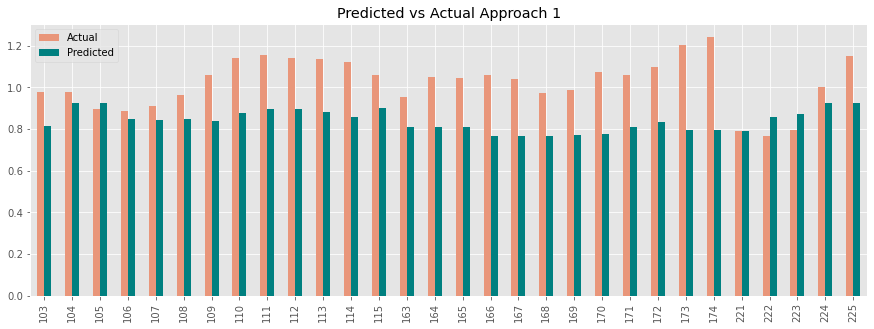

In [519]:
aux_plot_real_vs_pred(0, y_test_appch1_clean, y_pred_1_gbr)

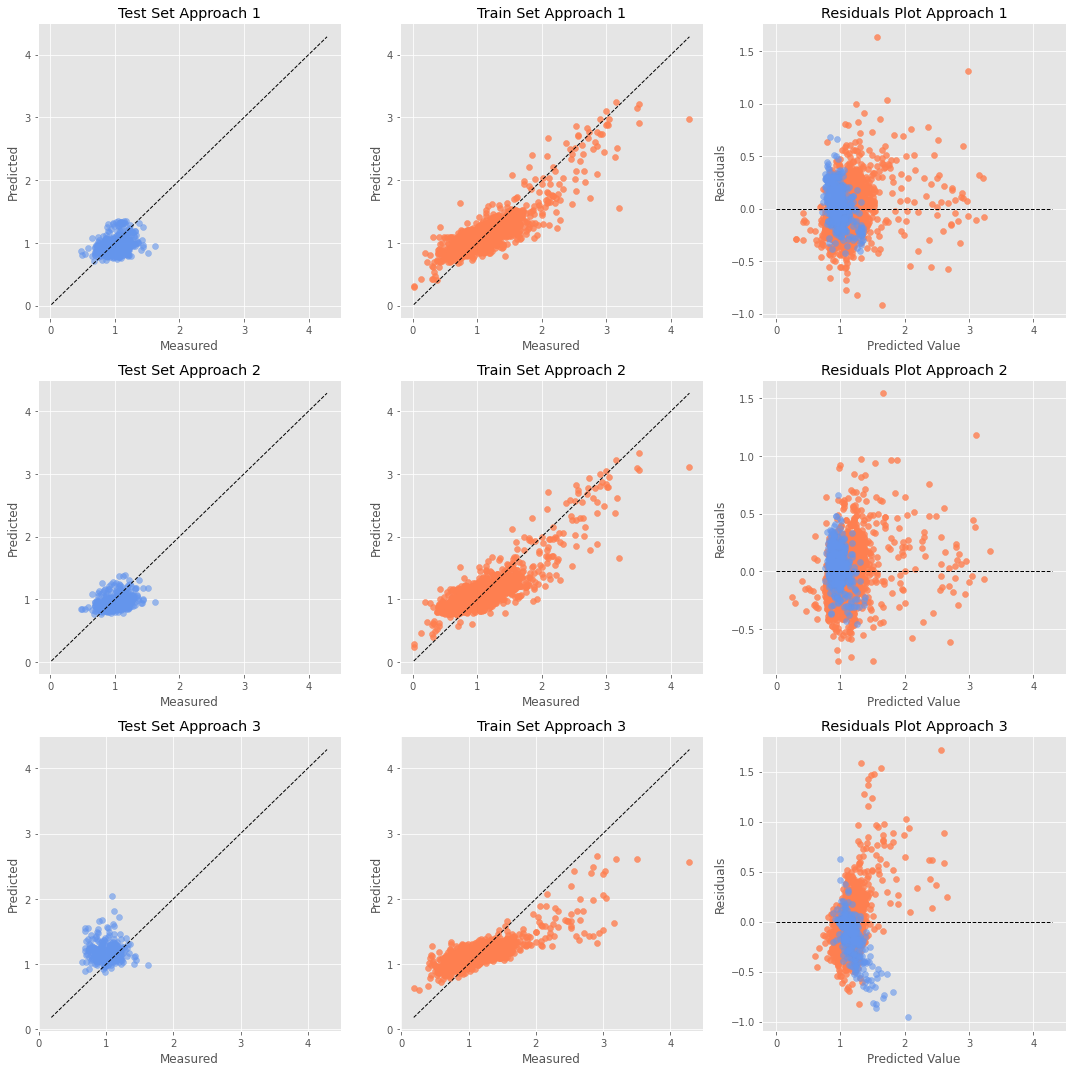

In [520]:
fig, ax = plt.subplots(3,3,figsize=(15,15))

plot_aux(0, y_test_appch1_clean, y_pred_1_gbr, y_train_appch1_clean, y_pred_train_1_gbr, ax)
plot_aux(1, y_test_appch2_clean, y_pred_2_gbr, y_train_appch2_clean, y_pred_train_2_gbr, ax)
plot_aux(2, y_test_appch3_clean, y_pred_3_gbr, y_train_appch3_clean, y_pred_train_3_gbr, ax)

fig.tight_layout()
plt.show()

* As seen Approach 3 using PCA seems to be the one getting the "best" results. However none of them seem to be fitting R0 correctly specially with larger values of R0.
* It is also important to note that the test set has a smaller rangeof values

## K Nearest Neighbour Regressor

In [521]:
reg1_knn = KNeighborsRegressor(n_neighbors=10)
reg2_knn = KNeighborsRegressor(n_neighbors=10)
reg3_knn = KNeighborsRegressor(n_neighbors=10)

reg1_knn.fit(X_train_appch1_clean, y_train_appch1_clean)
reg2_knn.fit(X_train_appch2_clean, y_train_appch2_clean)
reg3_knn.fit(X_train_appch3_clean, y_train_appch3_clean)

y_pred_1_knn=reg1_knn.predict(X_test_appch1_clean)
y_pred_train_1_knn=reg1_knn.predict(X_train_appch1_clean)
y_pred_2_knn=reg2_knn.predict(X_test_appch2_clean)
y_pred_train_2_knn=reg2_knn.predict(X_train_appch2_clean)
y_pred_3_knn=reg3_knn.predict(X_test_appch3_clean)
y_pred_train_3_knn=reg3_knn.predict(X_train_appch3_clean)

### Evaluation

#### Test Set

In [522]:
df_scores_knn=get_metrics_data_frame(y_test_appch1_clean,y_pred_1_knn, y_test_appch2_clean, y_pred_2_knn,y_test_appch3_clean, y_pred_3_knn)
df_eval_approach_2.loc['KNN'] = df_scores_knn.loc['Approach 2']
highlight_min(df_scores_knn)

,mae,mse,rmse,mape
Approach 1,0.161621,0.041163,0.202886,17.164857
Approach 2,0.168407,0.042723,0.206696,17.641576
Approach 3,0.224606,0.083109,0.288286,24.273202


#### Train Set

In [523]:
df_scores_knn_train=get_metrics_data_frame(y_train_appch1_clean,y_pred_train_1_knn, y_train_appch2_clean, y_pred_train_2_knn,y_train_appch3_clean, y_pred_train_3_knn)
highlight_min(df_scores_knn_train)

,mae,mse,rmse,mape
Approach 1,0.181707,0.078065,0.279401,22.256608
Approach 2,0.184149,0.076263,0.276157,22.375759
Approach 3,0.221383,0.114790,0.338807,20.206425


## Results View

#### Actual vs Predicted

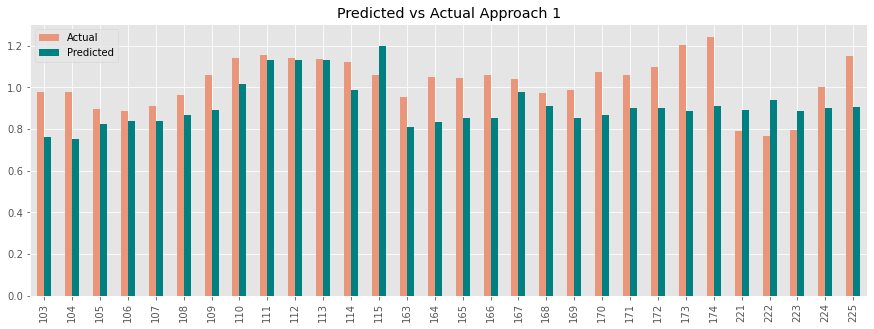

In [524]:
aux_plot_real_vs_pred(0, y_test_appch1_clean, y_pred_1_knn)

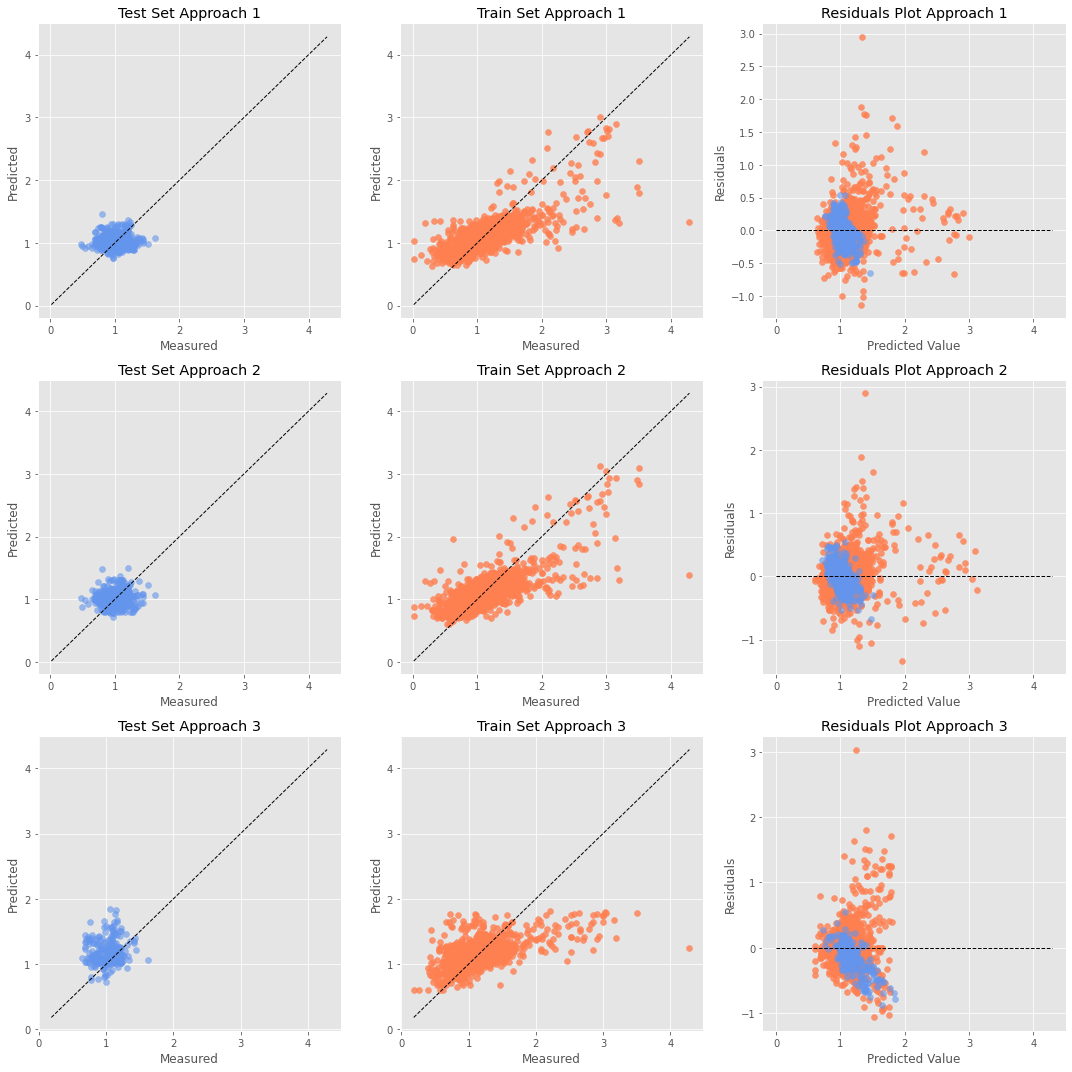

In [525]:
fig, ax = plt.subplots(3,3,figsize=(15,15))

plot_aux(0, y_test_appch1_clean, y_pred_1_knn, y_train_appch1_clean, y_pred_train_1_knn, ax)
plot_aux(1, y_test_appch2_clean, y_pred_2_knn, y_train_appch2_clean, y_pred_train_2_knn, ax)
plot_aux(2, y_test_appch3_clean, y_pred_3_knn, y_train_appch3_clean, y_pred_train_3_knn, ax)

fig.tight_layout()
plt.show()

* As seen Approach 3 using PCA seems to be the one getting the "best" results. However none of them seem to be fitting R0 correctly specially with larger values of R0.
* It is also important to note that the test set has a smaller rangeof values

## Histogram Gradient Boosting Regressor

In [526]:
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor
reg1_hist = HistGradientBoostingRegressor(max_depth=4)
reg2_hist = HistGradientBoostingRegressor(max_depth=4)
reg3_hist = HistGradientBoostingRegressor(max_depth=4)

reg1_hist.fit(X_train_appch1_clean, y_train_appch1_clean)
reg2_hist.fit(X_train_appch2_clean, y_train_appch2_clean)
reg3_hist.fit(X_train_appch3_clean, y_train_appch3_clean)

y_pred_1_hist=reg1_hist.predict(X_test_appch1_clean)
y_pred_train_1_hist=reg1_hist.predict(X_train_appch1_clean)
y_pred_2_hist=reg2_hist.predict(X_test_appch2_clean)
y_pred_train_2_hist=reg2_hist.predict(X_train_appch2_clean)
y_pred_3_hist=reg3_hist.predict(X_test_appch3_clean)
y_pred_train_3_hist=reg3_hist.predict(X_train_appch3_clean)

### Evaluation

#### Test Set

In [527]:
df_scores_hist=get_metrics_data_frame(y_test_appch1_clean,y_pred_1_hist, y_test_appch2_clean, y_pred_2_hist,y_test_appch3_clean, y_pred_3_hist)
df_eval_approach_2.loc['Histogram Gradient Boosting'] = df_scores_hist.loc['Approach 2']
highlight_min(df_scores_hist)

,mae,mse,rmse,mape
Approach 1,0.152145,0.036914,0.192131,14.998252
Approach 2,0.147275,0.034152,0.184803,14.603855
Approach 3,0.224662,0.085986,0.293234,24.585292


#### Train Set

In [528]:
df_scores_hist_train=get_metrics_data_frame(y_train_appch1_clean,y_pred_train_1_hist, y_train_appch2_clean, y_pred_train_2_hist,y_train_appch3_clean, y_pred_train_3_hist)
highlight_min(df_scores_hist_train)

,mae,mse,rmse,mape
Approach 1,0.136599,0.037059,0.192506,16.148185
Approach 2,0.141438,0.038985,0.197447,16.113100
Approach 3,0.177351,0.071687,0.267744,16.556294


## Results View

#### Actual vs Predicted

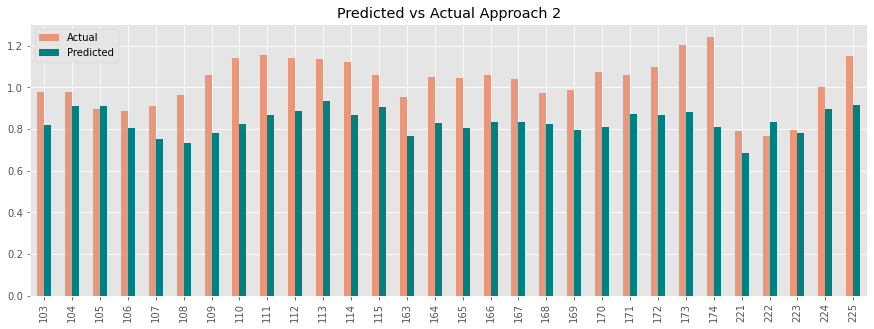

In [529]:
aux_plot_real_vs_pred(1, y_test_appch2_clean, y_pred_2_hist)

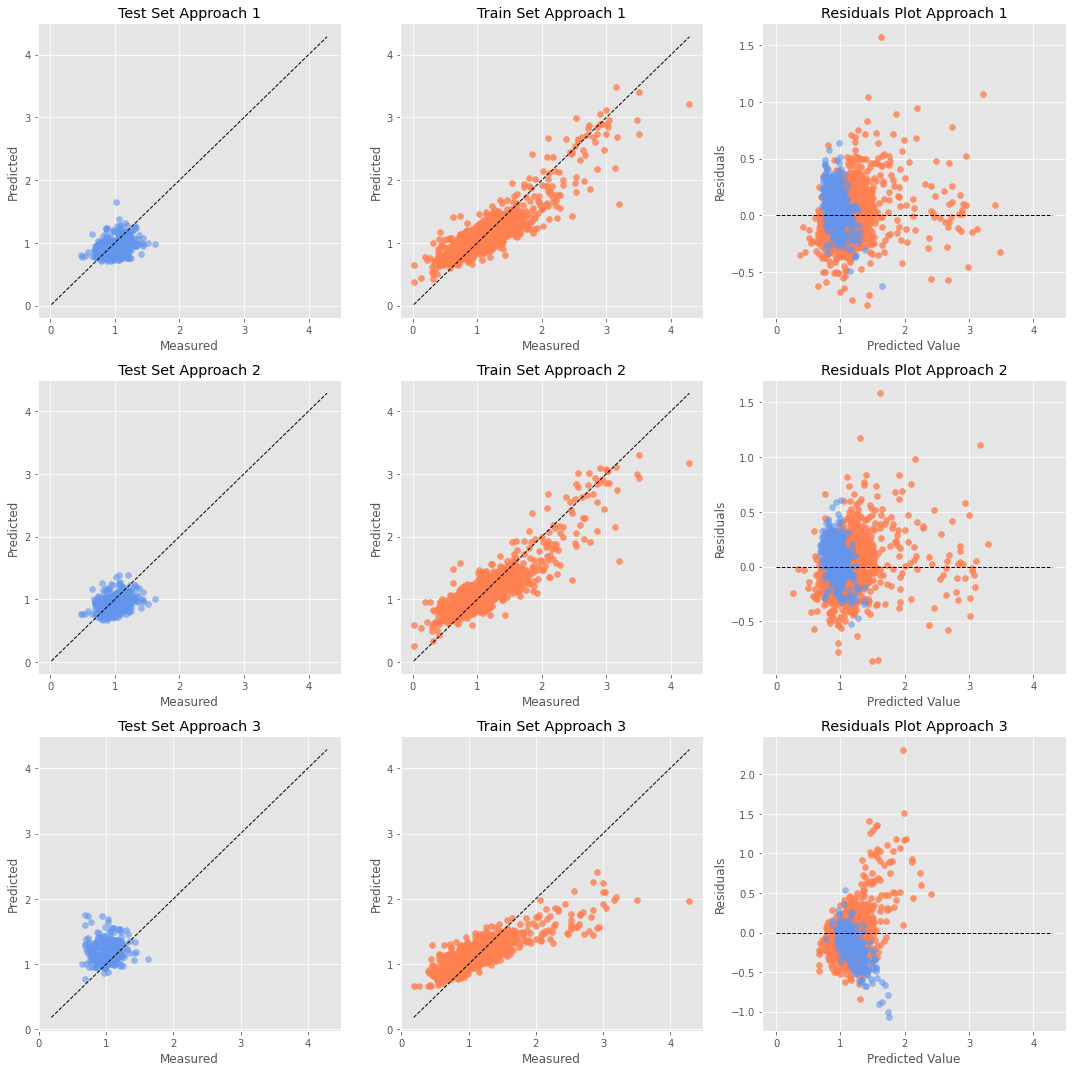

In [530]:
fig, ax = plt.subplots(3,3,figsize=(15,15))

plot_aux(0, y_test_appch1_clean, y_pred_1_hist, y_train_appch1_clean, y_pred_train_1_hist, ax)
plot_aux(1, y_test_appch2_clean, y_pred_2_hist, y_train_appch2_clean, y_pred_train_2_hist, ax)
plot_aux(2, y_test_appch3_clean, y_pred_3_hist, y_train_appch3_clean, y_pred_train_3_hist, ax)

fig.tight_layout()
plt.show()

## NuSVR

In [531]:
from sklearn.svm import NuSVR
reg1_nusvr = NuSVR(C=1.0, nu=0.1)
reg2_nusvr = NuSVR(C=1.0, nu=0.1)
reg3_nusvr = NuSVR(C=1.0, nu=0.1)

reg1_nusvr.fit(X_train_appch1_clean, y_train_appch1_clean)
reg2_nusvr.fit(X_train_appch2_clean, y_train_appch2_clean)
reg3_nusvr.fit(X_train_appch3_clean, y_train_appch3_clean)

y_pred_1_nusvr=reg1_nusvr.predict(X_test_appch1_clean)
y_pred_train_1_nusvr=reg1_nusvr.predict(X_train_appch1_clean)
y_pred_2_nusvr=reg2_nusvr.predict(X_test_appch2_clean)
y_pred_train_2_nusvr=reg2_nusvr.predict(X_train_appch2_clean)
y_pred_3_nusvr=reg3_nusvr.predict(X_test_appch3_clean)
y_pred_train_3_nusvr=reg3_nusvr.predict(X_train_appch3_clean)

### Evaluation

#### Test Set

In [532]:
df_scores_NuSVR=get_metrics_data_frame(y_test_appch1_clean,y_pred_1_nusvr, y_test_appch2_clean, y_pred_2_nusvr,y_test_appch3_clean, y_pred_3_nusvr)
df_eval_approach_2.loc['NuSVR'] = df_scores_NuSVR.loc['Approach 2']
highlight_min(df_scores_NuSVR)

,mae,mse,rmse,mape
Approach 1,0.187102,0.054880,0.234265,20.068736
Approach 2,0.184975,0.053336,0.230945,20.191336
Approach 3,0.248758,0.092541,0.304206,27.271603


#### Train Set

In [533]:
df_scores_NuSVR_train=get_metrics_data_frame(y_train_appch1_clean,y_pred_train_1_nusvr, y_train_appch2_clean, y_pred_train_2_nusvr,y_train_appch3_clean, y_pred_train_3_nusvr)
highlight_min(df_scores_NuSVR_train)

,mae,mse,rmse,mape
Approach 1,0.195519,0.060573,0.246115,22.254591
Approach 2,0.207621,0.072194,0.268690,23.585251
Approach 3,0.257659,0.122230,0.349614,25.102827


## Results View

#### Actual vs Predicted

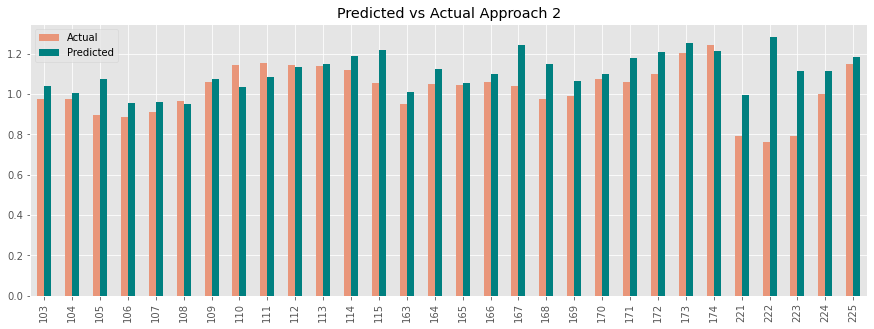

In [534]:
aux_plot_real_vs_pred(1, y_test_appch2_clean, y_pred_2_nusvr)

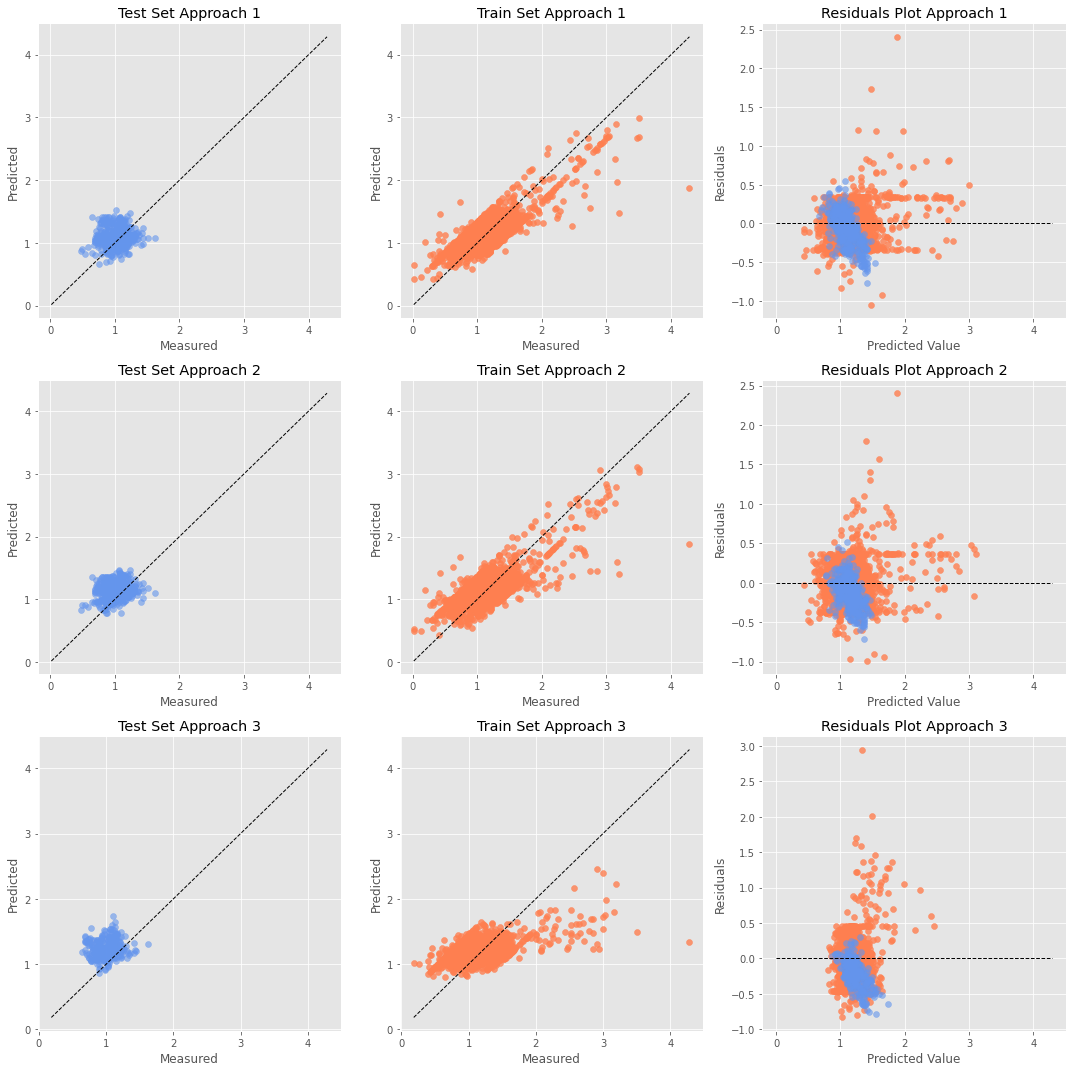

In [535]:
fig, ax = plt.subplots(3,3,figsize=(15,15))

plot_aux(0, y_test_appch1_clean, y_pred_1_nusvr, y_train_appch1_clean, y_pred_train_1_nusvr, ax)
plot_aux(1, y_test_appch2_clean, y_pred_2_nusvr, y_train_appch2_clean, y_pred_train_2_nusvr, ax)
plot_aux(2, y_test_appch3_clean, y_pred_3_nusvr, y_train_appch3_clean, y_pred_train_3_nusvr, ax)

fig.tight_layout()
plt.show()

## Comparing Three Models with Three Approaches

In [536]:
xgb_mae, lgb_mae, gbst_mae, knn_mae, hist_mae, NuSVR_mae = get_values_metric('mae')
xgb_mse, lgb_mse, gbst_mse, knn_mse, hist_mae, NuSVR_mae = get_values_metric('mse')
xgb_rmse, lgb_rmse, gbst_rmse, knn_rmse, hist_mae, NuSVR_mae = get_values_metric('rmse')
xgb_mape, lgb_mape, gbst_mape, knn_mape, hist_mae, NuSVR_mae = get_values_metric('mape')

xgb_mae=xgb_mae.sort_index(ascending=False)
lgb_mae=lgb_mae.sort_index(ascending=False)
gbst_mae=gbst_mae.sort_index(ascending=False)
knn_mae=knn_mae.sort_index(ascending=False)
hist_mae=knn_mae.sort_index(ascending=False)
NuSVR_mae=knn_mae.sort_index(ascending=False)

xgb_mse=xgb_mse.sort_index(ascending=False)
lgb_mse=lgb_mse.sort_index(ascending=False)
gbst_mse=gbst_mse.sort_index(ascending=False)
knn_mse=knn_mse.sort_index(ascending=False)
hist_mse=knn_mse.sort_index(ascending=False)
NuSVR_mse=knn_mse.sort_index(ascending=False)

xgb_rmse=xgb_rmse.sort_index(ascending=False)
lgb_rmse=lgb_rmse.sort_index(ascending=False)
gbst_rmse=gbst_rmse.sort_index(ascending=False)
knn_rmse=knn_rmse.sort_index(ascending=False)
hist_rmse=knn_rmse.sort_index(ascending=False)
NuSVR_rmse=knn_rmse.sort_index(ascending=False)

xgb_mape=xgb_mape.sort_index(ascending=False)
lgb_mape=lgb_mape.sort_index(ascending=False)
gbst_mape=gbst_mape.sort_index(ascending=False)
knn_mape=knn_mape.sort_index(ascending=False)
hist_mape=knn_mape.sort_index(ascending=False)
NuSVR_mape=knn_mape.sort_index(ascending=False)

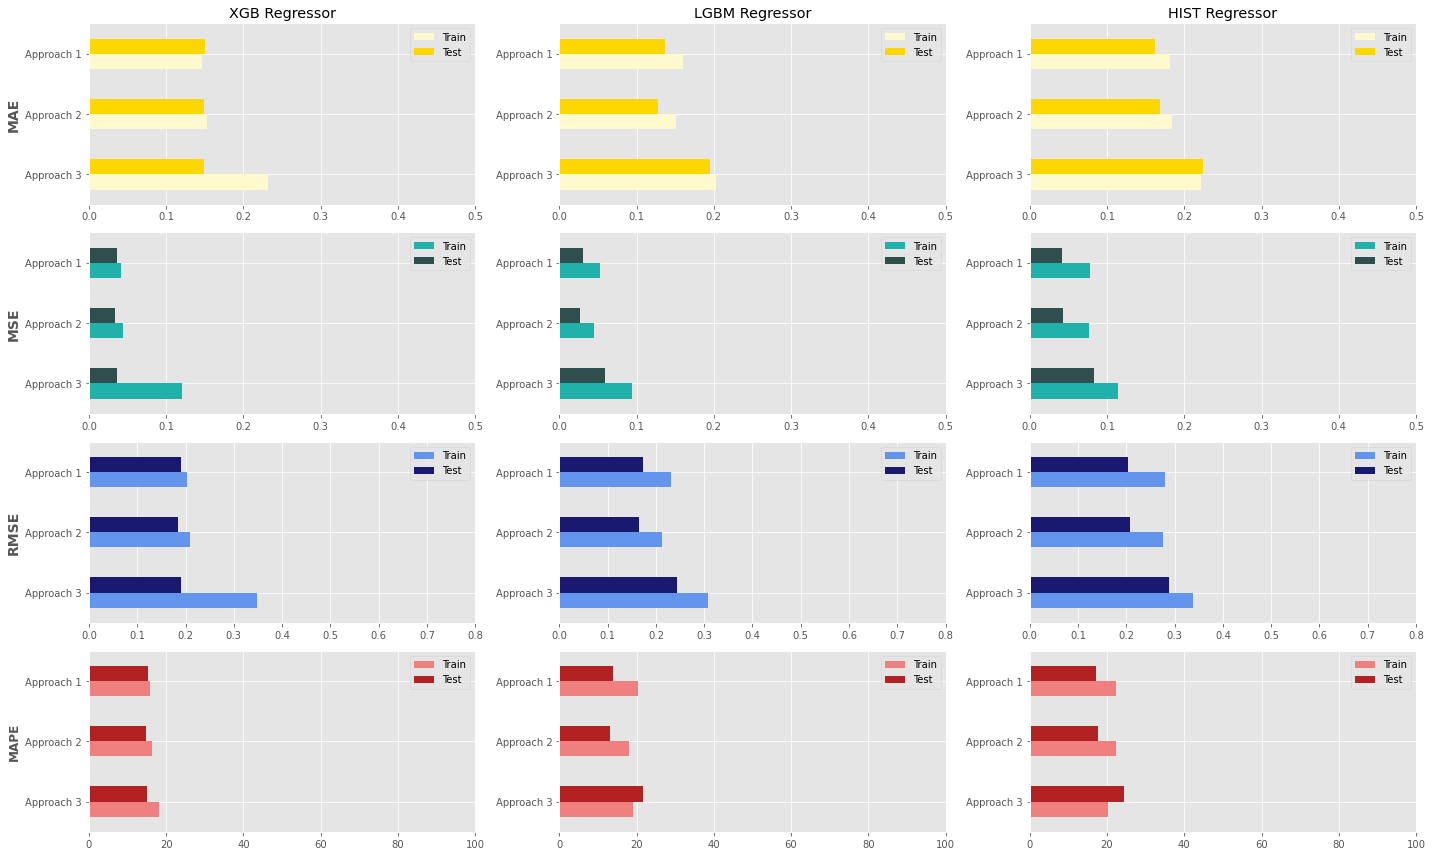

In [537]:
fig, ax = plt.subplots(4,3,figsize=(20,12))

xgb_mae.plot.barh(ax=ax[0][0], color=["lemonchiffon","gold"],title = 'XGB Regressor').set_ylabel('MAE', fontsize=14.0, fontweight='bold')
lgb_mae.plot.barh(ax=ax[0][1], color=["lemonchiffon","gold"],title = 'LGBM Regressor')
hist_mae.plot.barh(ax=ax[0][2], color=["lemonchiffon","gold"],title = 'HIST Regressor')
xgb_mse.plot.barh(ax=ax[1][0], color=["lightseagreen","darkslategray"]).set_ylabel('MSE', fontsize=14.0, fontweight='bold')
lgb_mse.plot.barh(ax=ax[1][1], color=["lightseagreen","darkslategray"])
hist_mse.plot.barh(ax=ax[1][2], color=["lightseagreen","darkslategray"])
xgb_rmse.plot.barh(ax=ax[2][0], color=["cornflowerblue","midnightblue"]).set_ylabel('RMSE', fontsize=14.0, fontweight='bold')
lgb_rmse.plot.barh(ax=ax[2][1], color=["cornflowerblue","midnightblue"])
hist_rmse.plot.barh(ax=ax[2][2], color=["cornflowerblue","midnightblue"])
xgb_mape.plot.barh(ax=ax[3][0], color=["lightcoral","firebrick"]).set_ylabel('MAPE',fontsize=12.0, fontweight='bold')
lgb_mape.plot.barh(ax=ax[3][1], color=["lightcoral","firebrick"])
hist_mape.plot.barh(ax=ax[3][2], color=["lightcoral","firebrick"])

ax[0][0].set_xlim([0, 0.5])
ax[0][1].set_xlim([0, 0.5])
ax[0][2].set_xlim([0, 0.5])

ax[1][0].set_xlim([0, 0.5])
ax[1][1].set_xlim([0, 0.5])
ax[1][2].set_xlim([0, 0.5])

ax[2][0].set_xlim([0, 0.8])
ax[2][1].set_xlim([0, 0.8])
ax[2][2].set_xlim([0, 0.8])

ax[3][0].set_xlim([0, 100])
ax[3][1].set_xlim([0, 100])
ax[3][2].set_xlim([0, 100])

fig.tight_layout()

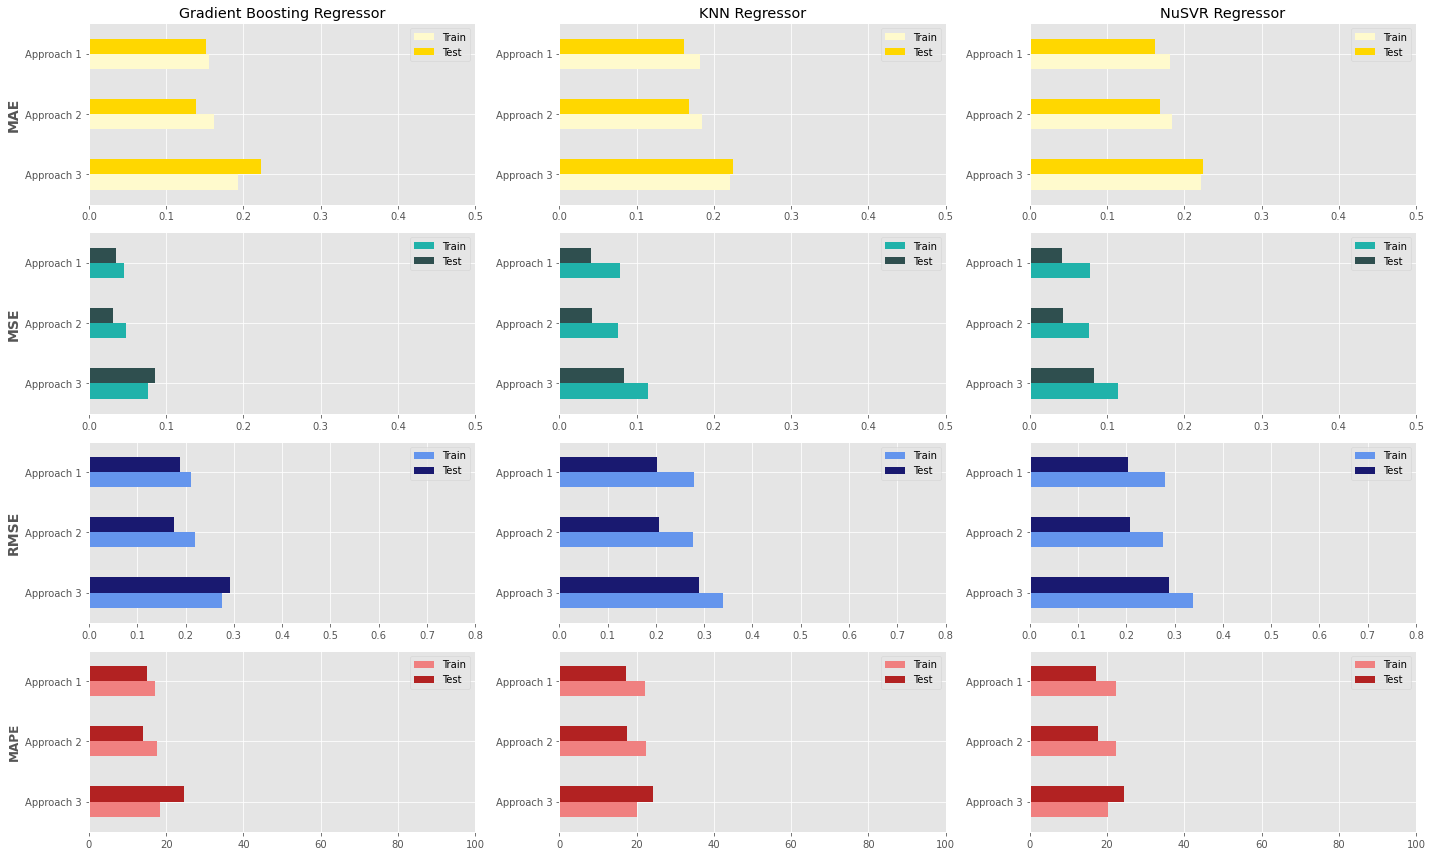

In [538]:
fig, ax = plt.subplots(4,3,figsize=(20,12))

gbst_mae.plot.barh(ax=ax[0][0], color=["lemonchiffon","gold"],title = 'Gradient Boosting Regressor').set_ylabel('MAE', fontsize=14.0, fontweight='bold')
knn_mae.plot.barh(ax=ax[0][1], color=["lemonchiffon","gold"],title = 'KNN Regressor')
NuSVR_mae.plot.barh(ax=ax[0][2], color=["lemonchiffon","gold"],title = 'NuSVR Regressor')
gbst_mse.plot.barh(ax=ax[1][0], color=["lightseagreen","darkslategray"]).set_ylabel('MSE', fontsize=14.0, fontweight='bold')
knn_mse.plot.barh(ax=ax[1][1], color=["lightseagreen","darkslategray"])
NuSVR_mse.plot.barh(ax=ax[1][2], color=["lightseagreen","darkslategray"])
gbst_rmse.plot.barh(ax=ax[2][0], color=["cornflowerblue","midnightblue"]).set_ylabel('RMSE', fontsize=14.0, fontweight='bold')
knn_rmse.plot.barh(ax=ax[2][1], color=["cornflowerblue","midnightblue"])
NuSVR_rmse.plot.barh(ax=ax[2][2], color=["cornflowerblue","midnightblue"])
gbst_mape.plot.barh(ax=ax[3][0], color=["lightcoral","firebrick"]).set_ylabel('MAPE',fontsize=12.0, fontweight='bold')
knn_mape.plot.barh(ax=ax[3][1], color=["lightcoral","firebrick"])
NuSVR_mape.plot.barh(ax=ax[3][2], color=["lightcoral","firebrick"])

ax[0][0].set_xlim([0, 0.5])
ax[0][1].set_xlim([0, 0.5])
ax[0][2].set_xlim([0, 0.5])

ax[1][0].set_xlim([0, 0.5])
ax[1][1].set_xlim([0, 0.5])
ax[1][2].set_xlim([0, 0.5])

ax[2][0].set_xlim([0, 0.8])
ax[2][1].set_xlim([0, 0.8])
ax[2][2].set_xlim([0, 0.8])

ax[3][0].set_xlim([0, 100])
ax[3][1].set_xlim([0, 100])
ax[3][2].set_xlim([0, 100])

fig.tight_layout()

## Evaluating Results for Approach 2

* As mentioned, approach 2 seems to be the most replicable and explainable model, therefore we will work with this model. 
* We will look at the metrics mae, mse, rmse and mape of all regressor used and compare them visually.

Text(0.5, 1.0, 'MAPE')

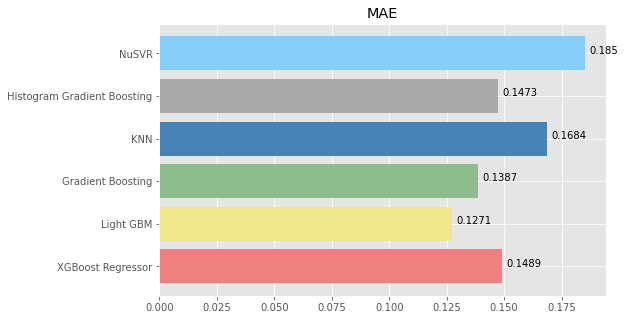

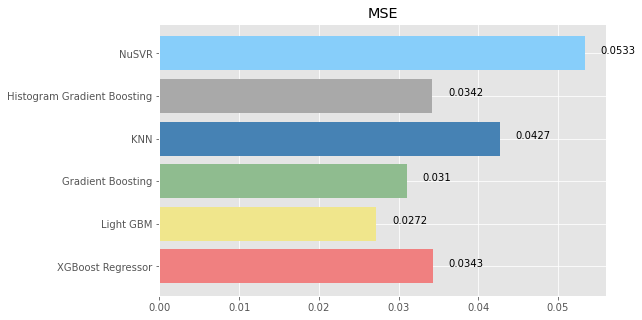

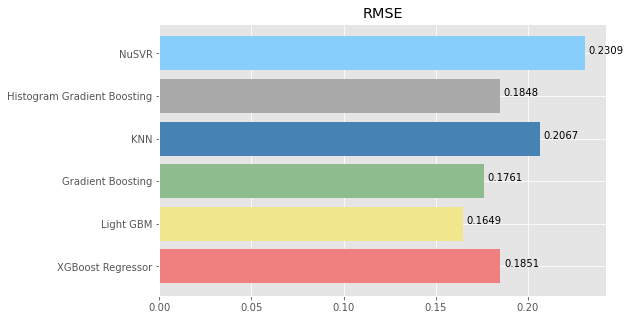

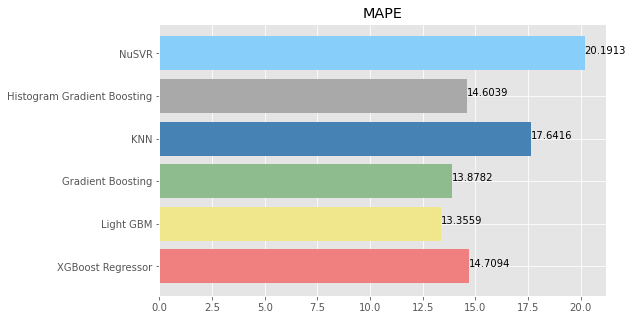

In [539]:
colors = ['lightcoral', 'khaki', 'darkseagreen', 'steelblue', 'darkgray', 'lightskyblue']
y=np.round(df_eval_approach_2['mae'], decimals=4)

fig, ax = plt.subplots(figsize=(8, 5)) 
ind=np.arange(len(df_eval_approach_2))
ax.barh(ind, df_eval_approach_2['mae'], color=colors)
plt.yticks(ind,df_eval_approach_2.index.tolist())

for i, v in enumerate(y):
    ax.text(v+0.002, i, str(v), color='black')
ax.set_title('MAE')

y=np.round(df_eval_approach_2['mse'], decimals=4)

fig, ax = plt.subplots(figsize=(8, 5)) 
ind=np.arange(len(df_eval_approach_2))
ax.barh(ind, df_eval_approach_2['mse'], color=colors)
plt.yticks(ind,df_eval_approach_2.index.tolist())

for i, v in enumerate(y):
    ax.text(v+0.002, i, str(v), color='black')
ax.set_title('MSE')

y=np.round(df_eval_approach_2['rmse'], decimals=4)

fig, ax = plt.subplots(figsize=(8, 5)) 
ind=np.arange(len(df_eval_approach_2))
ax.barh(ind, df_eval_approach_2['rmse'], color=colors)
plt.yticks(ind,df_eval_approach_2.index.tolist())

for i, v in enumerate(y):
    ax.text(v+0.002, i, str(v), color='black')
ax.set_title('RMSE')

y=np.round(df_eval_approach_2['mape'], decimals=4)

fig, ax = plt.subplots(figsize=(8, 5)) 
ind=np.arange(len(df_eval_approach_2))
ax.barh(ind, df_eval_approach_2['mape'], color=colors)
plt.yticks(ind,df_eval_approach_2.index.tolist())

for i, v in enumerate(y):
    ax.text(v+0.002, i, str(v), color='black')
ax.set_title('MAPE')

## Time Series Split Evaluation Approach 2

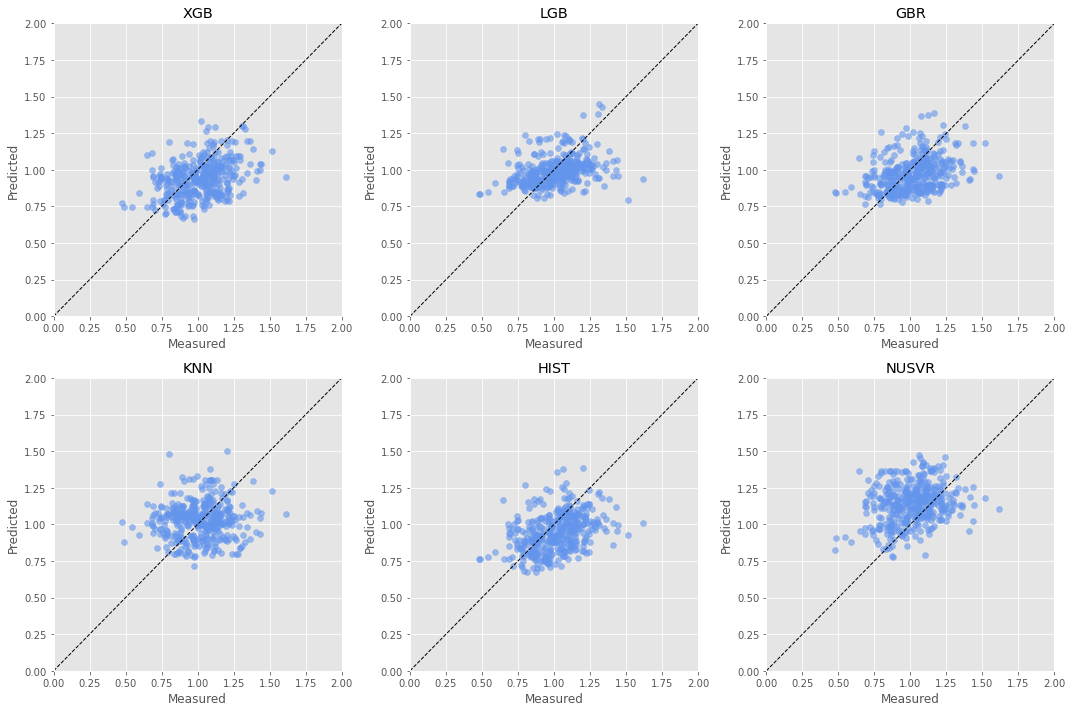

In [540]:
fig, ax = plt.subplots(2,3,figsize=(15,10))

aux_plot_3('XGB', 0,0, y_test_appch2, y_pred_2_xgb, y_train_appch2, ax)
aux_plot_3('LGB', 0,1, y_test_appch2, y_pred_2_lgb, y_train_appch2, ax)
aux_plot_3('GBR', 0,2, y_test_appch2, y_pred_2_gbr, y_train_appch2, ax)
aux_plot_3('KNN', 1,0, y_test_appch2, y_pred_2_knn, y_train_appch2, ax)
aux_plot_3('HIST', 1,1, y_test_appch2, y_pred_2_hist, y_train_appch2, ax)
aux_plot_3('NUSVR', 1,2, y_test_appch2, y_pred_2_nusvr, y_train_appch2, ax)

fig.tight_layout()

We will perform time series evaluation on the selected models. Since time is not really our time unit, we will treat "accumulated" feature as time. We are doing this because, the virus landed atdifferent times in some countries, therfore the effect is not actually related to time, but to the time since the virus got introduced in a selected country. The best measure to simulize this behaviour is "accumulted" which contains the accumulated number of detahs until time n.
* We will perform 6 splits, with the selected top models, and compare them.

In [254]:
df_time=df_appch1_clean.copy()
df_time=df_time.sort_values('accumulated').reset_index()

In [255]:
df_time.head()

,index,Code,Date,retail_and_recreation,grocery_and_pharmacy,residential,transit_stations,parks,workplaces,debt_relief,...,holiday,temp,prcp,number_of_arrivals,urban_population,total_vaccinations_per_100,youth_unemployment,infections_value,accumulated,reproduction_rate
0,1237,GBR,2020-03-15,1.102000,1.061143,0.245000,-0.020286,0.530429,-0.305857,0.0,...,0.0,4.297501,0.155011,35814000.0,83.143,0.0,11.080000,-1.15,0.0,2.095000
1,762,DEU,2020-03-15,0.061429,4.490000,1.714286,-2.102000,7.285429,-5.244857,0.0,...,0.0,4.165919,0.051928,35555000.0,77.261,0.0,5.750000,-2.70,0.0,3.030000
2,763,DEU,2020-03-22,0.693857,4.693857,1.020429,-3.020429,8.469286,-0.245000,0.0,...,0.0,5.464165,0.076797,35555000.0,77.261,0.0,5.750000,0.96,0.0,3.001429
3,764,DEU,2020-03-29,-6.999857,8.448857,3.061143,-12.306143,18.081571,-4.489857,0.0,...,0.0,7.446386,0.008038,35555000.0,77.261,0.0,5.750000,4.04,0.0,2.855714
4,3351,SWE,2020-03-22,0.714143,1.245000,0.877429,-2.714286,9.877429,-1.489714,0.0,...,1.0,-0.216642,0.056435,6782000.0,87.146,0.0,20.219999,3.73,0.0,2.378000


### Gradient Boosting

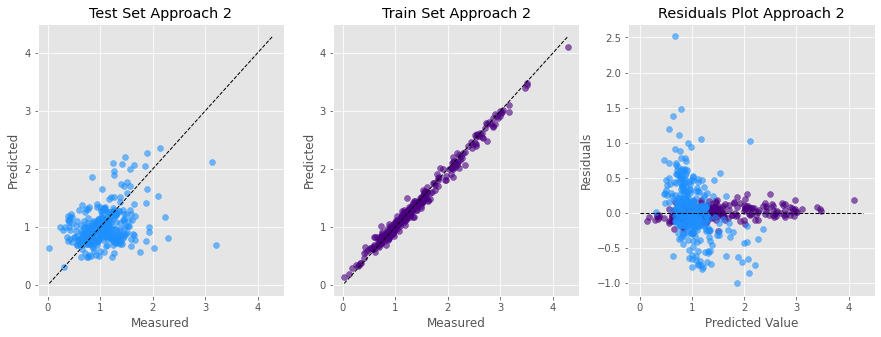

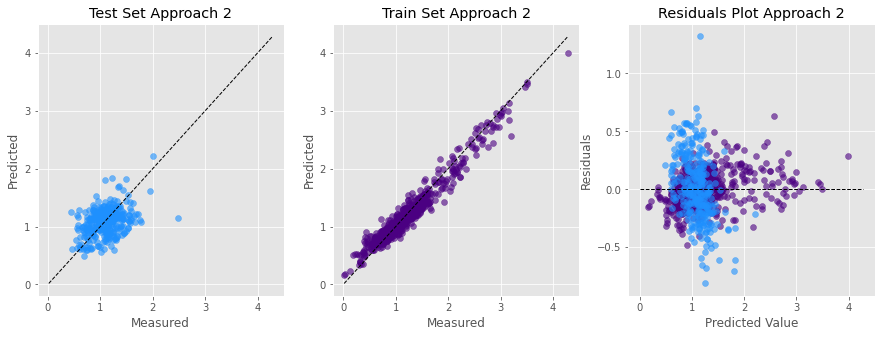

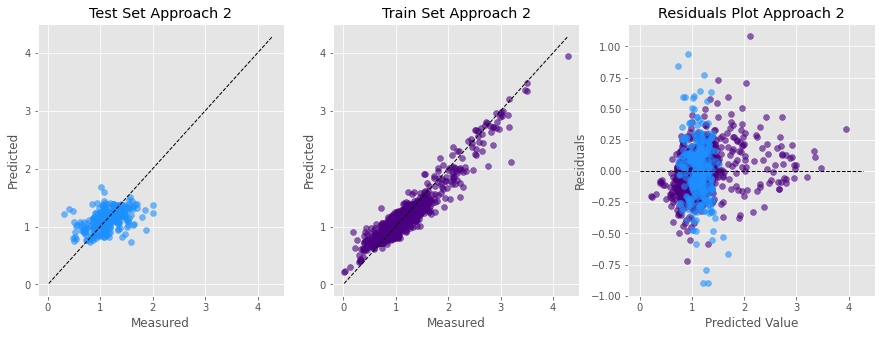

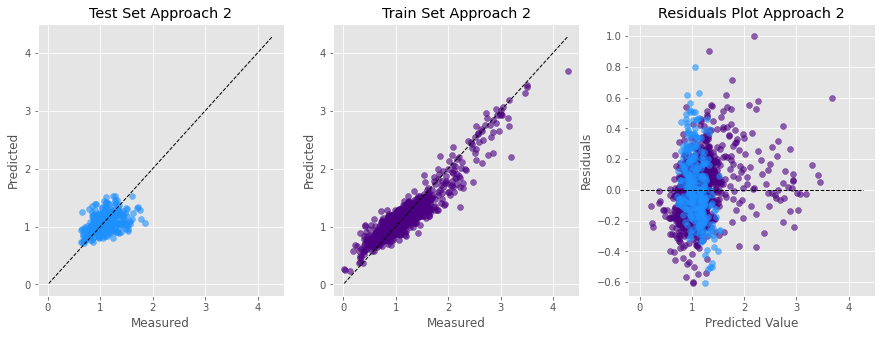

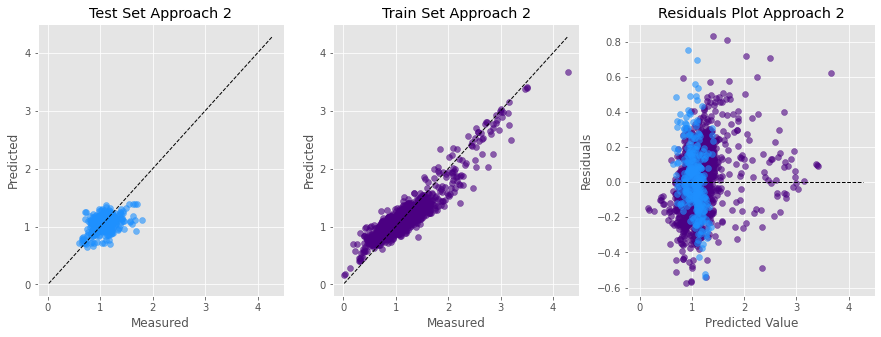

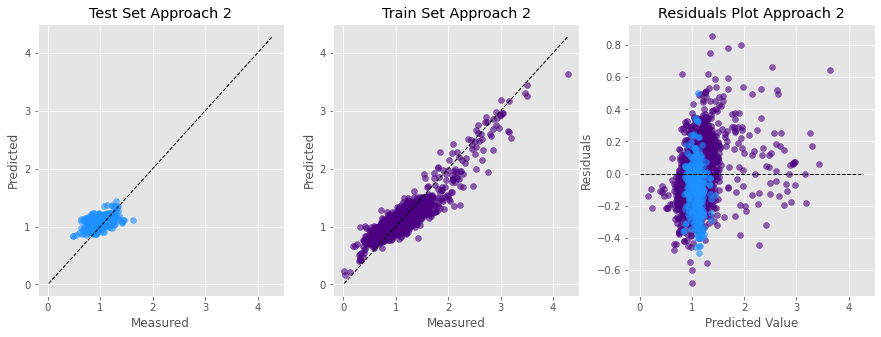

In [258]:
y=df_time[df_time.columns[-1]]

scaler = preprocessing.StandardScaler().fit(df_time[df_time.columns[3:-1]])

X = pd.DataFrame(scaler.transform(df_time[df_time.columns[3:-1]]), columns=df_time.columns[3:-1])

tscv = TimeSeriesSplit(n_splits=6)
aux_df=pd.DataFrame(columns=['mae', 'rmse', 'mse', 'mape'])
iter = 0
for train_index, test_index in tscv.split(X): 
    
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]    
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    

    model = GradientBoostingRegressor(max_depth=4)
    model.fit(X_train, y_train)
    y_pred=model.predict(X_test)
    y_pred_train=model.predict(X_train)
    
    fig, ax = plt.subplots(1,3,figsize=(15,5))
    plot_aux_2(1,y_test, y_pred, y_train, y_pred_train, ax)
    
    mae = mean_squared_error(y_pred, y_test)
    rmse = np.sqrt(mean_squared_error(y_pred, y_test))
    mse = r2_score(y_pred, y_test)
    mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
    
    aux_df.loc['Fold ' + str(iter)]=[mae, rmse, mse, mape]
    iter = iter+1

In [259]:
print('Average Test Mape: ' + str(aux_df['mape'].mean()))
print('Average Test Mae: ' + str(aux_df['mae'].mean()))
aux_df

Average Test Mape: 21.875376691435193
Average Test Mae: 0.07373394638143134


,mae,rmse,mse,mape
Fold 0,0.177135,0.420874,-0.710323,44.379439
Fold 1,0.082464,0.287165,-0.480794,21.816894
Fold 2,0.061998,0.248995,-1.190148,18.824920
Fold 3,0.050201,0.224055,-0.789552,16.070887
Fold 4,0.036809,0.191856,-0.729801,13.703466
Fold 5,0.033797,0.183840,-2.273155,16.456655


### Histogram Gradient Boosting

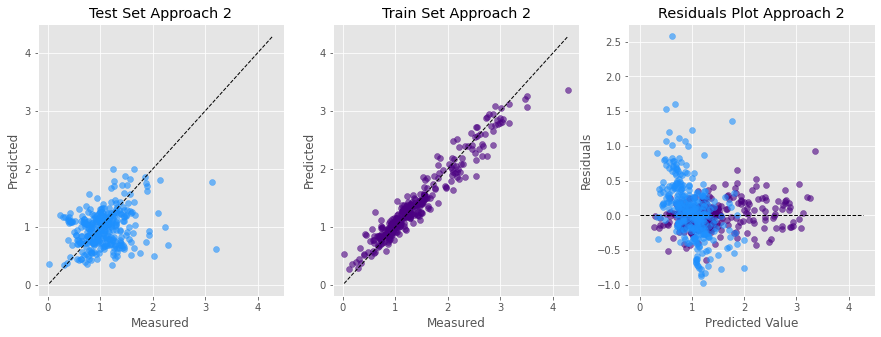

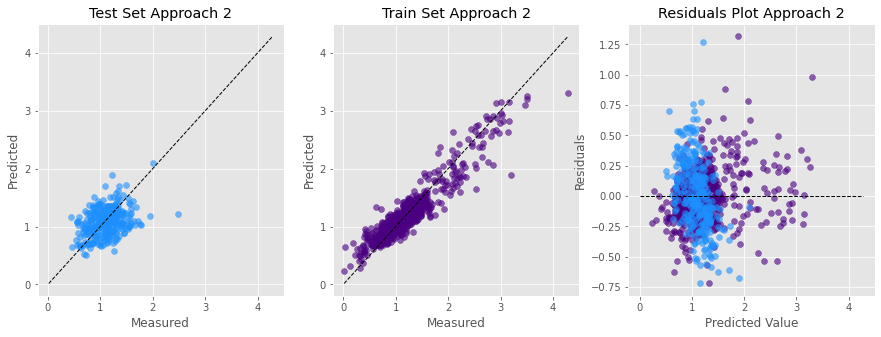

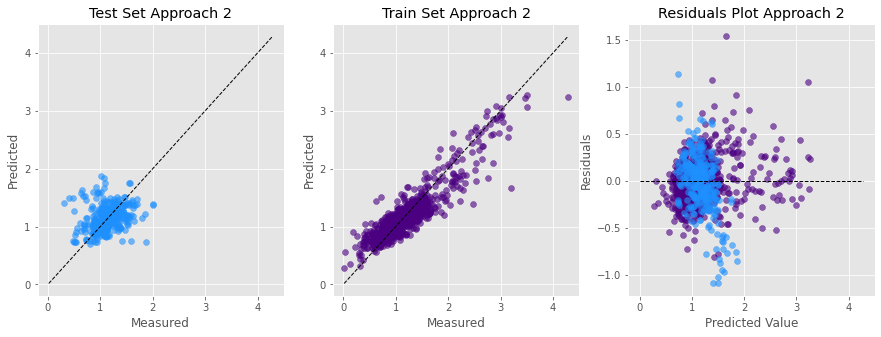

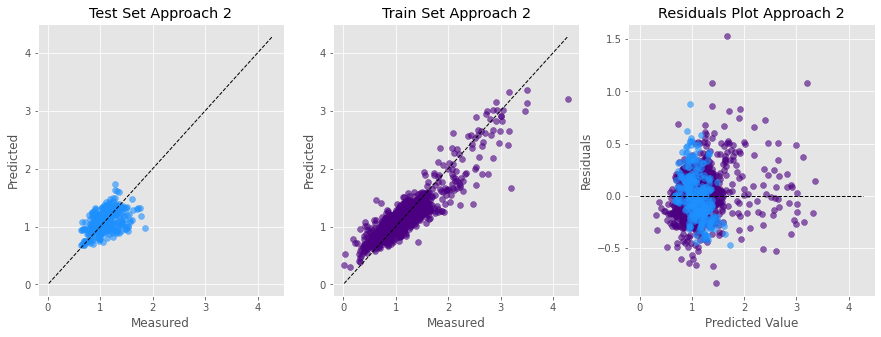

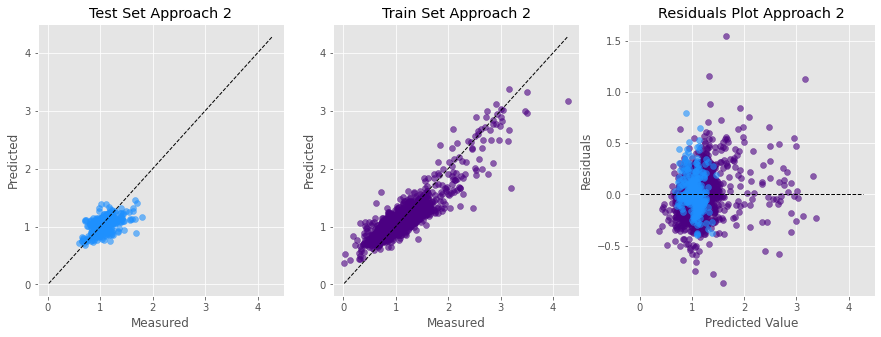

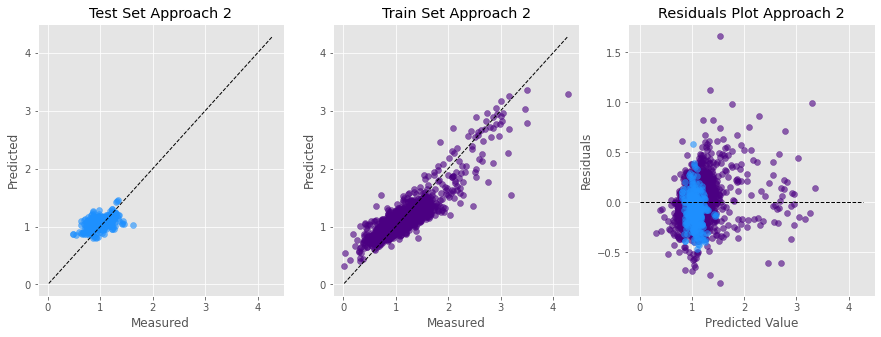

In [412]:
y=df_time[df_time.columns[-1]]

scaler = preprocessing.StandardScaler().fit(df_time[df_time.columns[3:-1]])

X = pd.DataFrame(scaler.transform(df_time[df_time.columns[3:-1]]), columns=df_time.columns[3:-1])

tscv = TimeSeriesSplit(n_splits=6)
aux_df=pd.DataFrame(columns=['mae', 'rmse', 'mse', 'mape'])
iter = 0
for train_index, test_index in tscv.split(X): 
    
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]    
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    

    model = HistGradientBoostingRegressor(max_depth=4)
    model.fit(X_train, y_train)
    y_pred=model.predict(X_test)
    y_pred_train=model.predict(X_train)
    
    fig, ax = plt.subplots(1,3,figsize=(15,5))
    plot_aux_2(1,y_test, y_pred, y_train, y_pred_train, ax)
    
    mae = mean_squared_error(y_pred, y_test)
    rmse = np.sqrt(mean_squared_error(y_pred, y_test))
    mse = r2_score(y_pred, y_test)
    mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
    
    aux_df.loc['Fold ' + str(iter)]=[mae, rmse, mse, mape]
    iter = iter+1

In [413]:
print('Average Test Mape: ' + str(aux_df['mape'].mean()))
print('Average Test Mae: ' + str(aux_df['mae'].mean()))
aux_df

Average Test Mape: 21.713027654870842
Average Test Mae: 0.08166375957696856


,mae,rmse,mse,mape
Fold 0,0.198421,0.445445,-0.998873,41.177848
Fold 1,0.086554,0.294200,-0.575246,22.485460
Fold 2,0.094497,0.307404,-0.963481,23.344031
Fold 3,0.049934,0.223460,-0.385177,16.207324
Fold 4,0.031429,0.177283,-0.646912,12.270556
Fold 5,0.029147,0.170725,-1.752780,14.792946


### XGB Regressor

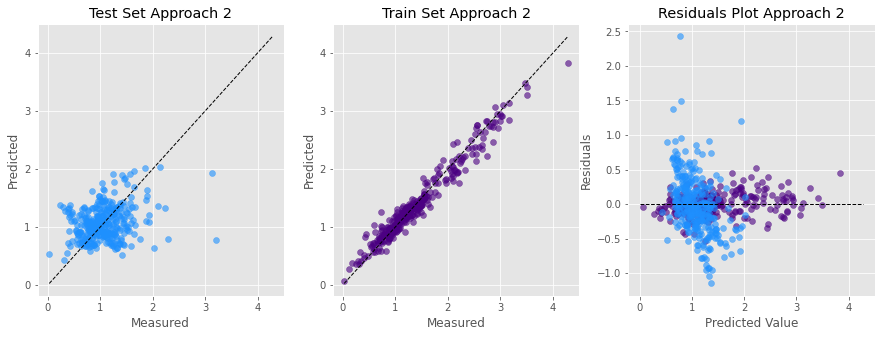

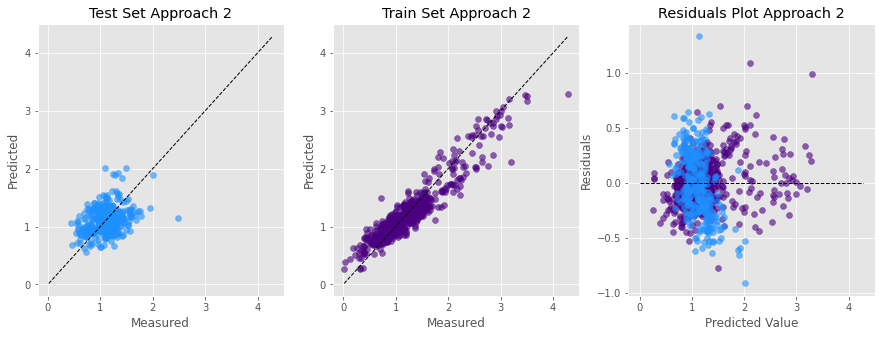

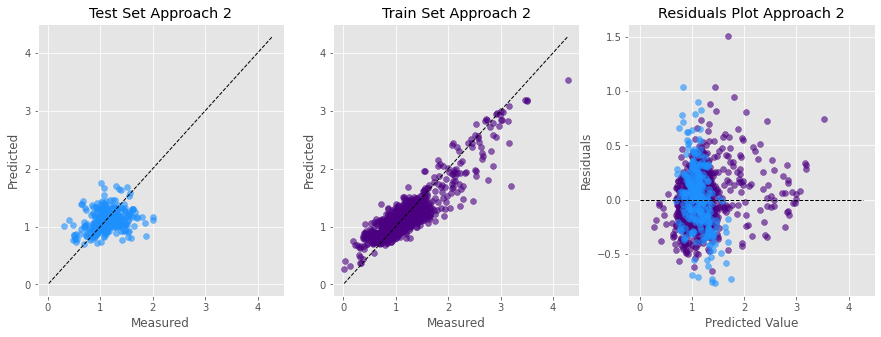

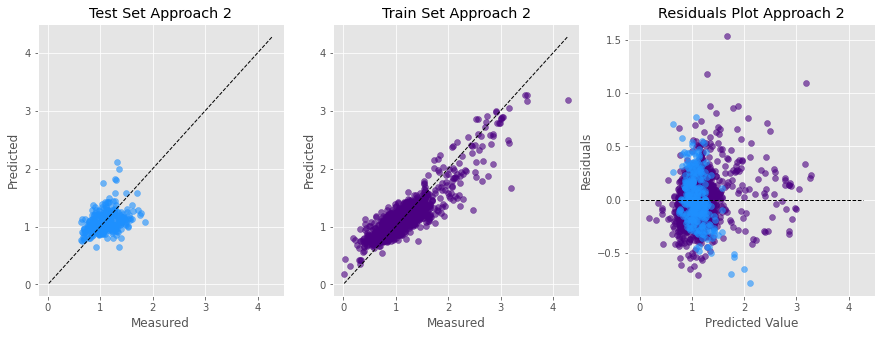

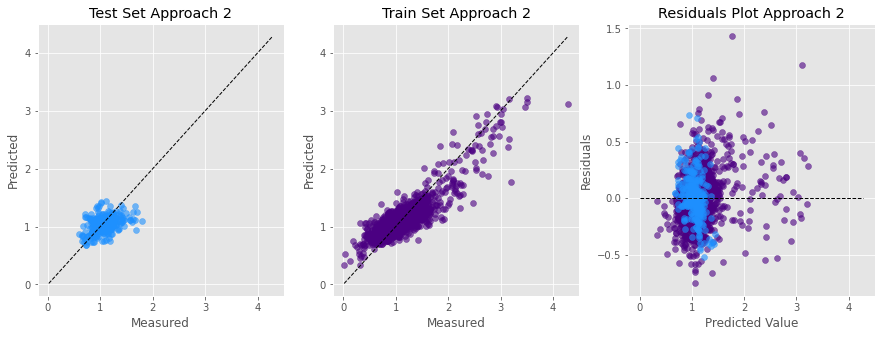

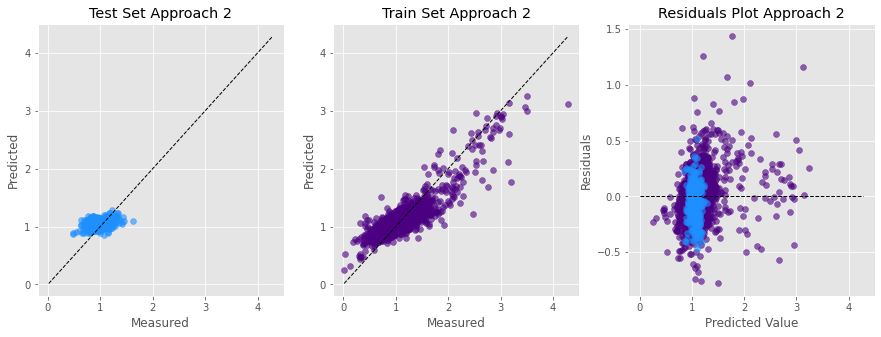

In [408]:
y=df_time[df_time.columns[-1]]

scaler = preprocessing.StandardScaler().fit(df_time[df_time.columns[3:-1]])

X = pd.DataFrame(scaler.transform(df_time[df_time.columns[3:-1]]), columns=df_time.columns[3:-1])

tscv = TimeSeriesSplit(n_splits=6)
aux_df=pd.DataFrame(columns=['mae', 'rmse', 'mse', 'mape'])
iter = 0
for train_index, test_index in tscv.split(X): 
    
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]    
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    

    model=XGBRegressor(n_estimators=20,max_depth= 4, colsample_bytree=0.5, early_stopping_rounds=5, verbosity=0)
    model.fit(X_train, y_train)
    y_pred=model.predict(X_test)
    y_pred_train=model.predict(X_train)
    
    fig, ax = plt.subplots(1,3,figsize=(15,5))
    plot_aux_2(1,y_test, y_pred, y_train, y_pred_train, ax)
    
    mae = mean_squared_error(y_pred, y_test)
    rmse = np.sqrt(mean_squared_error(y_pred, y_test))
    mse = r2_score(y_pred, y_test)
    mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
    
    aux_df.loc['Fold ' + str(iter)]=[mae, rmse, mse, mape]
    iter = iter+1

In [409]:
print('Average Test Mape: ' + str(aux_df['mape'].mean()))
print('Average Test Mae: ' + str(aux_df['mae'].mean()))
aux_df

Average Test Mape: 22.943359291893174
Average Test Mae: 0.08061330110279233


,mae,rmse,mse,mape
Fold 0,0.183414,0.428269,-1.129189,46.006207
Fold 1,0.094027,0.306639,-0.669924,24.692660
Fold 2,0.082448,0.287138,-1.411550,21.117010
Fold 3,0.055222,0.234995,-0.605607,16.572478
Fold 4,0.038239,0.195548,-1.095887,13.882310
Fold 5,0.030329,0.174152,-4.020447,15.389491


In [435]:
import pickle
model = GradientBoostingRegressor(max_depth=4)
model.fit(X_train_appch2_clean, y_train_appch2)
pickle.dump(model, open('model_hist_reg', 'wb'))
pickle.dump(scaler_appch2, open('scaler', 'wb'))

In [429]:
!pwd

/Users/lucas_botella/Downloads


In [471]:
X_train_appch2.infections_value.min()

-95.59

In [444]:
X_train_appch2.columns

Index(['mobility_index', 'residential', 'awareness_measures',
       'health_measures', 'mobility_measures', 'economic_measures',
       'closure_measures', 'holiday', 'temp', 'prcp', 'number_of_arrivals',
       'urban_population', 'total_vaccinations_per_100', 'youth_unemployment',
       'infections_value', 'accumulated'],
      dtype='object')

In [460]:
df[df['holiday']==7]

,Code,Date,retail_and_recreation,grocery_and_pharmacy,residential,transit_stations,parks,workplaces,debt_relief,income_support,...,holiday,temp,prcp,number_of_arrivals,urban_population,total_vaccinations_per_100,youth_unemployment,infections_value,accumulated,reproduction_rate
1582,ISR,2020-04-26,-83.428714,-25.775571,29.816286,-63.918286,-64.163143,-68.244857,2.0,2.0,...,7.0,16.463542,0.04375,2900000.0,92.336,0.0,6.68,5.61,0.004132,0.908571
